Import needed stuff

In [11]:
import requests
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
from matplotlib import pyplot as plt
import seaborn as sns
import networkscience as ns
import pycountry as pc

## Mobility of Countries

In [12]:
def create_position(score_df, label):
    scores = score_df.sort_values(label, ascending=False)
    scores[label+' position']= (np.arange(len(scores.index))+1)
    return scores
def analysis(country_df):
    country_df = country_df[country_df['Participant Profile']=='Learner']
    country_df = country_df[country_df['Activity (mob)'].str.contains('Student')]
    country_df = country_df[~country_df['Activity (mob)'].str.contains('traineeship')]
    nodes = np.array(list(set.union(set(country_df.loc[:, 'Sending Country Code' ]), set(country_df.loc[:, 'Receiving Country Code']))))
    country_df.dropna(how='any', inplace=True)
    # I don't want it to take forever
    node_position = {}
    for i, name in enumerate(nodes):
        node_position[name] = i
    nodes_df = pd.DataFrame({'Nodes': nodes})
    country_df['SendId'] = (np.array(list(map(lambda x: node_position[x], country_df['Sending Country Code']))))
    country_df['RecId']= (np.array(list(map(lambda x: node_position[x], country_df['Receiving Country Code']))))
    # Adjacency matrix
    country_serie = country_df[['SendId', 'RecId', 'Participants']].groupby(['SendId', 'RecId']).sum()
    row = np.array(country_serie.index.get_level_values(1).tolist())
    col = np.array(country_serie.index.get_level_values(0).tolist())
    val = country_serie.values
    adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    def replace_iso3166(alpha):
        try:
            return pc.countries.get(alpha_2=alpha).name
        except:
            return alpha

    country_df['Receiving Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Receiving Country Code']))))
    country_df['Sending Country Code']= (np.array(list(map(lambda x: replace_iso3166(x), country_df['Sending Country Code']))))
    nodes_df['Nodes'] = (np.array(list(map(lambda x: replace_iso3166(x), nodes_df['Nodes']))))

    ns.visualize_adj(adj_matrix_crs)
    matr = adj_matrix_crs.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()
    country_df.rename({'Sending Country Code': 'source', 'Receiving Country Code':'target', 'Participants':'weight'},axis=1, inplace=True)
    components = ns.find_components(adj_matrix_crs, nodes_df)
    unique, counts = np.unique(components['component'], return_counts=True)
    print('Number of components =', len(unique))
    scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
    ns.display_top_n(scores, 10, 'in degree')
    ns.display_top_n(scores, 10, 'out degree')
    df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')
    ns.display_top_n(scores, 10, 'hits hub')
    ns.display_top_n(scores, 10, 'hits autority')
    df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
    scores = pd.merge(scores, df, on='Nodes')

    ns.display_top_n(scores, 10, 'PageRank hub')
    ns.display_top_n(scores, 10, 'PageRank authority')

    sns.pairplot(scores)
    plt.show()
    scores = create_position(scores, 'in degree')
    scores = create_position(scores, 'out degree')
    scores = create_position(scores, 'hits hub')
    scores = create_position(scores, 'hits autority')
    scores = create_position(scores, 'PageRank hub')
    scores = create_position(scores, 'PageRank authority')
    scores.sort_index(inplace=True)
    n = 40
    pd.set_option('display.max_rows', n)
    display(scores.sort_values('PageRank authority', ascending=False)[['Nodes', 'in degree', 'in degree position', 'hits autority', 'hits autority position', 'PageRank authority', 'PageRank authority position']].head(n))
    display(scores.sort_values('PageRank hub', ascending=False)[['Nodes', 'out degree', 'out degree position', 'hits hub', 'hits hub position', 'PageRank hub', 'PageRank hub position']].head(n))
    edges = country_df[['source','target']].copy()
    print(ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True))
    # label = 'PageRank autority position'
    label = 'in degree position'
    c = country_df.drop(['SendId', 'RecId'],axis=1)
    another_order = scores[['Nodes', label]].copy()
    another_order[label] = another_order[label] - 1
    another_order.rename({'Nodes':'source', label: 'source ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="source")
    another_order.rename({'source':'target', 'source ID': 'target ID'}, axis=1, inplace=True)
    c = pd.merge(c, another_order, on="target")
    c = c[['source ID', 'target ID', 'weight']]
    c_serie = c.groupby(['source ID', 'target ID']).sum()
    row = np.array(c_serie.index.get_level_values(1).tolist())
    col = np.array(c_serie.index.get_level_values(0).tolist())
    val = c_serie.values
    or_adj = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

    ns.visualize_adj(or_adj)
    matr = or_adj.toarray()
    matr[matr>1]=1
    matr = matr - matr.T
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(matr, cmap="Blues", ax=ax)
    plt.show()

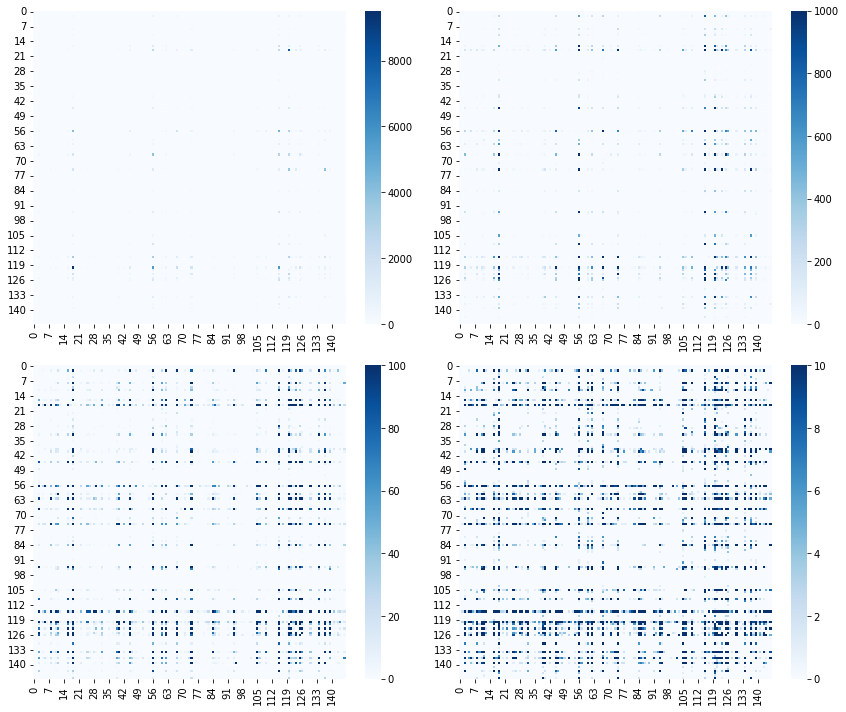

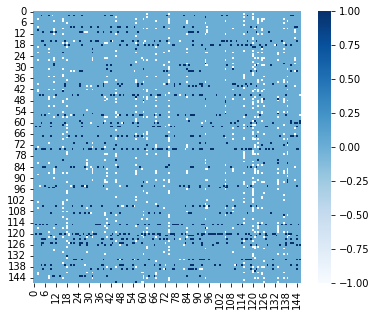

Number of components = 2


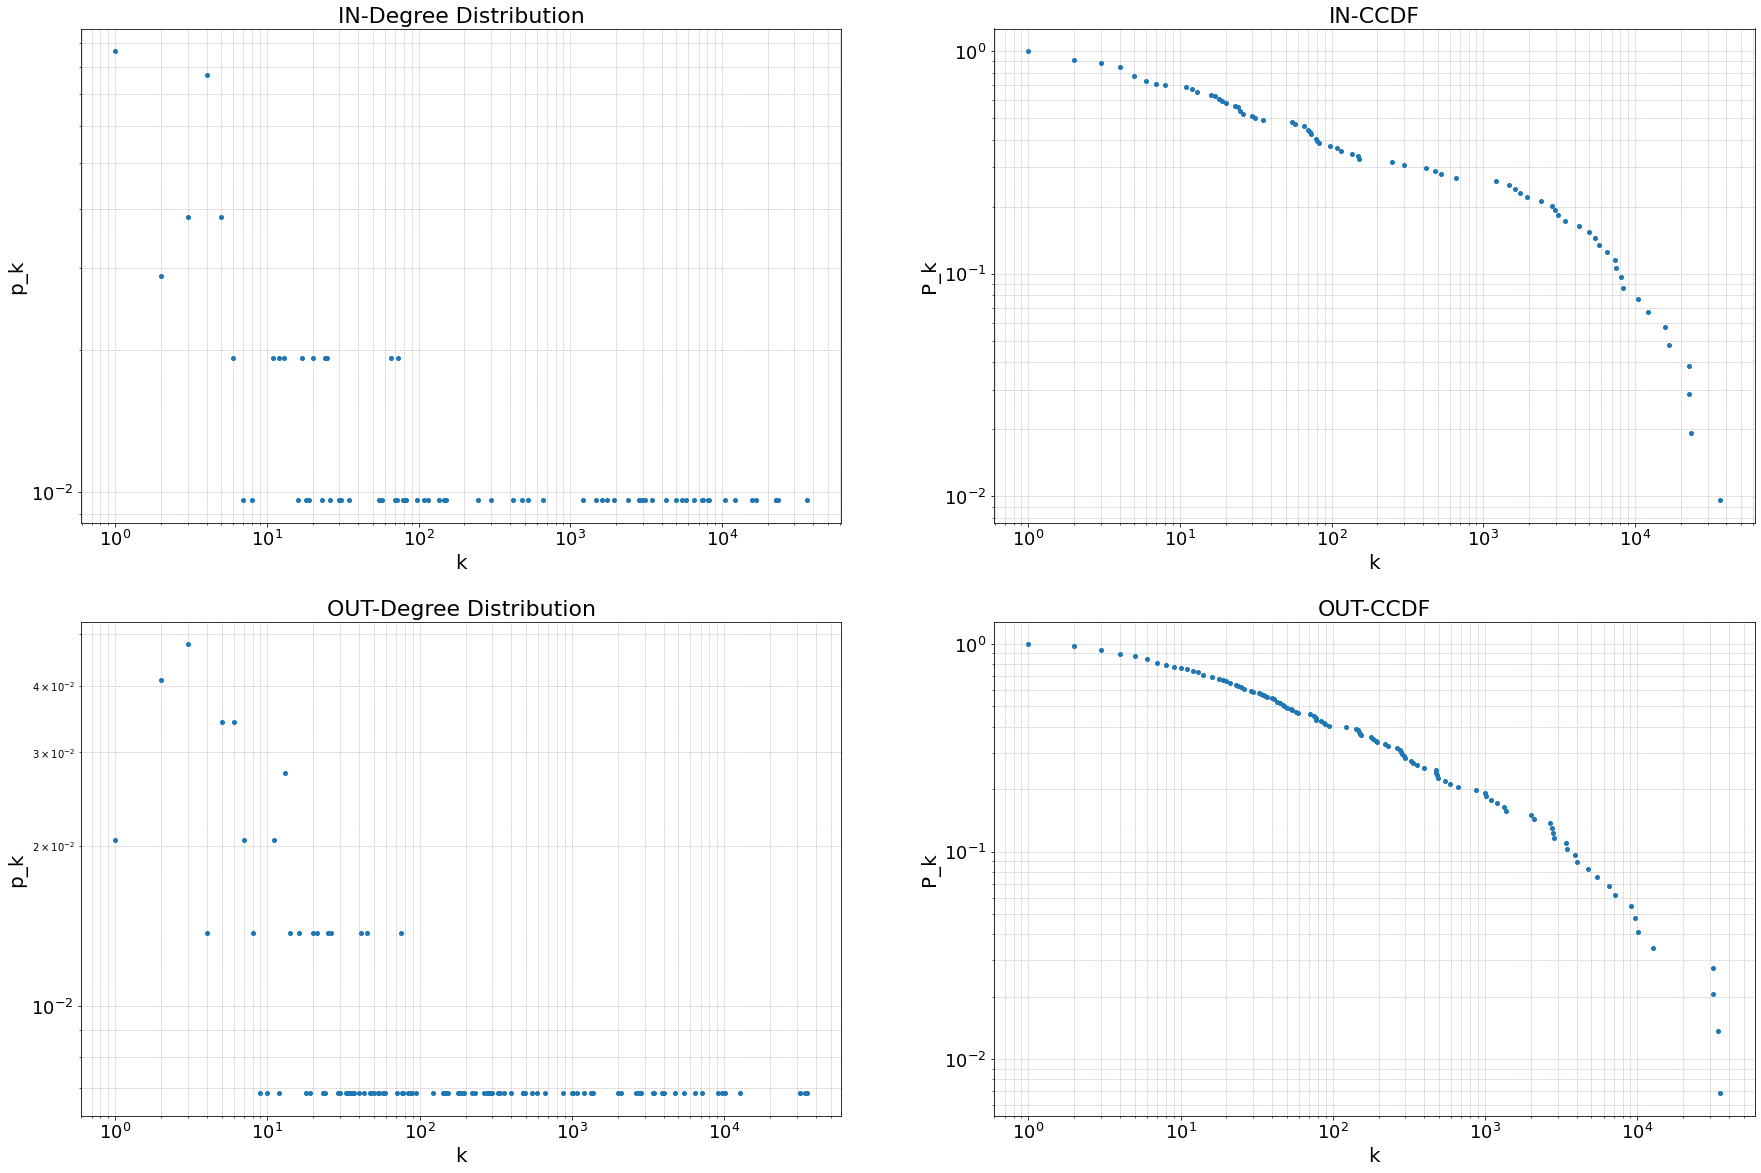

Top 10 for in degree


Nodes  in degree
120        Spain      36263
18         Italy      23344
56        France      22790
115      Germany      22538
67            UK      16849
74        Poland      15750
123     Portugal      12151
125  Netherlands      10510
126       Sweden       8268
134      Czechia       8079

Top 10 for out degree


Nodes  out degree
120        Spain       34913
115      Germany       33931
18         Italy       31591
56        France       31235
137       Turkey       12738
125  Netherlands       10144
74        Poland        9630
67            UK        9086
123     Portugal        7144
45       Belgium        6471

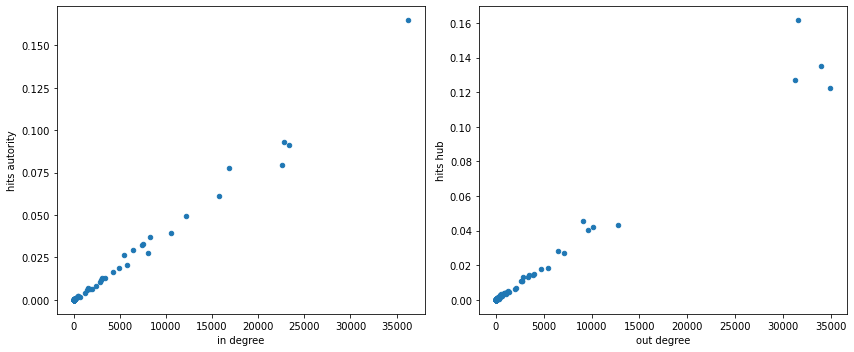

Top 10 for hits hub


Nodes  hits hub
18         Italy  0.161576
115      Germany  0.135408
56        France  0.127085
120        Spain  0.122200
67            UK  0.045554
137       Turkey  0.043050
125  Netherlands  0.042306
74        Poland  0.040657
45       Belgium  0.028275
123     Portugal  0.027016

Top 10 for hits autority


Nodes  hits autority
120        Spain       0.164803
56        France       0.093283
18         Italy       0.091191
115      Germany       0.079345
67            UK       0.077596
74        Poland       0.061080
123     Portugal       0.049354
125  Netherlands       0.039346
126       Sweden       0.036828
16       Finland       0.033024

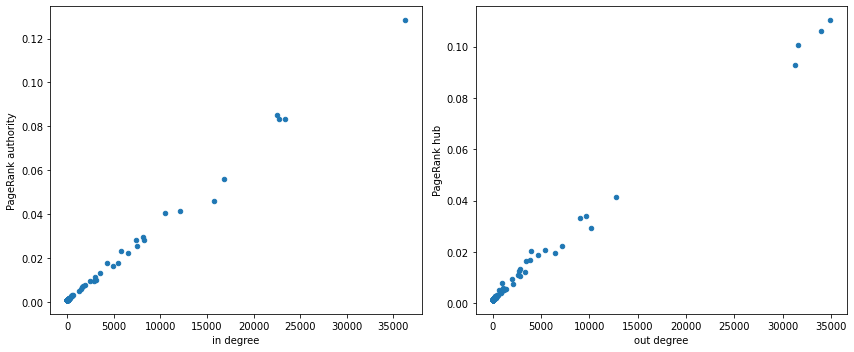

Top 10 for PageRank hub


Nodes  PageRank hub
120        Spain      0.110257
115      Germany      0.105996
18         Italy      0.100815
56        France      0.093048
137       Turkey      0.041473
74        Poland      0.033889
67            UK      0.033424
125  Netherlands      0.029289
123     Portugal      0.022390
134      Czechia      0.020962

Top 10 for PageRank authority


Nodes  PageRank authority
120        Spain            0.128283
115      Germany            0.084965
18         Italy            0.083311
56        France            0.083270
67            UK            0.056150
74        Poland            0.046034
123     Portugal            0.041512
125  Netherlands            0.040408
134      Czechia            0.029744
45       Belgium            0.028452

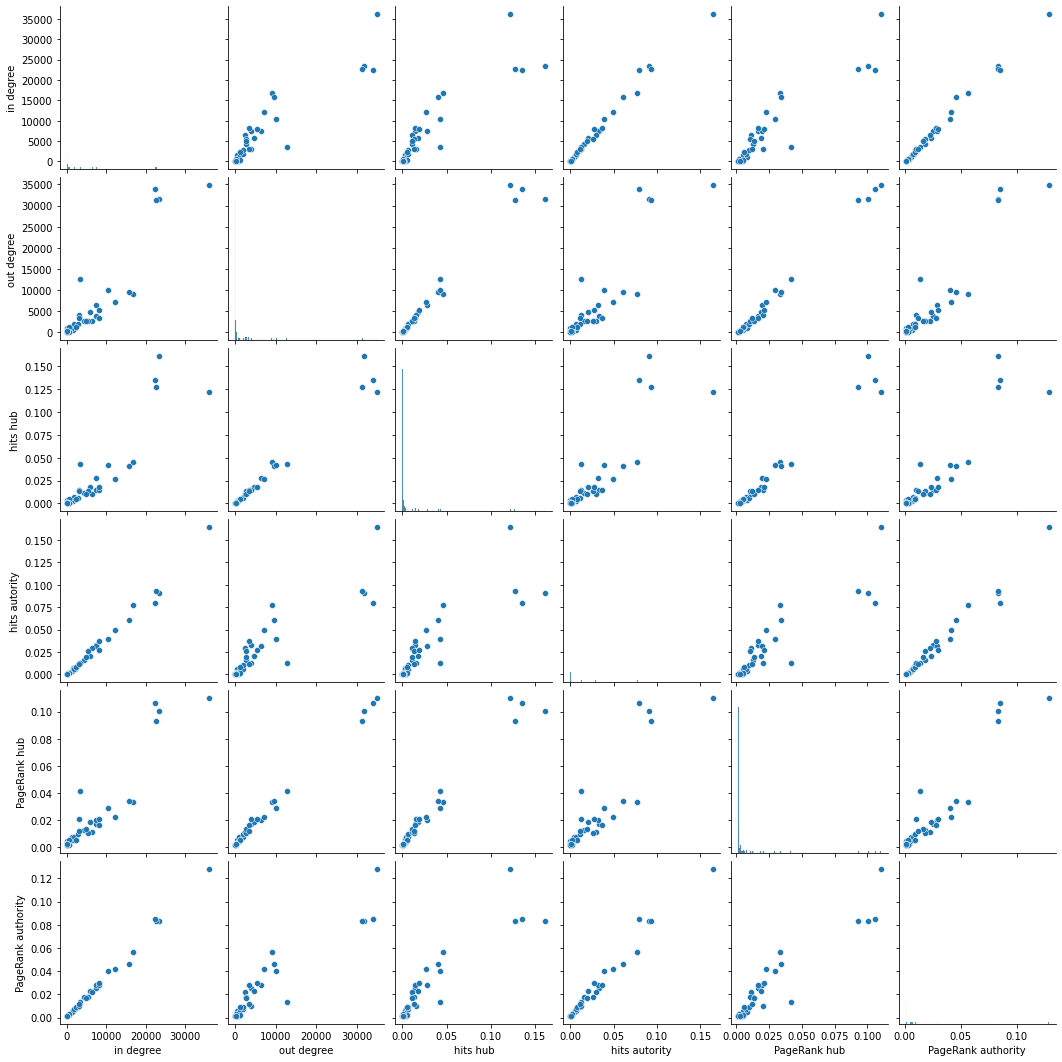

Nodes  in degree  in degree position  hits autority  \
120               Spain      36263                   1       0.164803   
115             Germany      22538                   4       0.079345   
18                Italy      23344                   2       0.091191   
56               France      22790                   3       0.093283   
67                   UK      16849                   5       0.077596   
74               Poland      15750                   6       0.061080   
123            Portugal      12151                   7       0.049354   
125         Netherlands      10510                   8       0.039346   
134             Czechia       8079                  10       0.027760   
45              Belgium       7416                  12       0.032101   
126              Sweden       8268                   9       0.036828   
16              Finland       7517                  11       0.033024   
62              Austria       5808                  14       0.020285   
94               Norway       6494                  13       0.029125   
109             Ireland       5419                  15       0.026383   
2               Denmark       4293                  17       0.016299   
121             Hungary       4948                  16       0.018998   
137              Turkey       3461                  18       0.012586   
139                  EL       2975                  20       0.011472   
105             Romania       3090                  19       0.012937   
60            Lithuania       2826                  21       0.010807   
84             Slovenia       2402                  22       0.008168   
8               Croatia       1949                  23       0.006518   
40             Slovakia       1735                  24       0.006356   
11               Latvia       1615                  25       0.006811   
32              Estonia       1478                  26       0.006028   
39             Bulgaria       1204                  27       0.004279   
95               Cyprus        659                  28       0.001930   
143             Iceland        528                  29       0.002094   
130  Russian Federation        483                  30       0.001973   
71                Malta        421                  31       0.001527   
28               Israel        298                  32       0.001121   
29           Luxembourg        152                  34       0.000671   
10               Serbia        248                  33       0.000994   
31               Canada        115                  37       0.000421   
82        United States        137                  36       0.000587   
146     North Macedonia        148                  35       0.000588   
46               Jordan        109                  38       0.000457   
22                China         70                  46       0.000134   
106             Ukraine         73                  43       0.000168   

     hits autority position  PageRank authority  PageRank authority position  
120                       1            0.128283                            1  
115                       4            0.084965                            2  
18                        3            0.083311                            3  
56                        2            0.083270                            4  
67                        5            0.056150                            5  
74                        6            0.046034                            6  
123                       7            0.041512                            7  
125                       8            0.040408                            8  
134                      13            0.029744                            9  
45                       11            0.028452                           10  
126                       9            0.028061                           11  
16                       10            0.025517                           12

Nodes  out degree  out degree position  hits hub  \
120                   Spain       34913                    1  0.122200   
115                 Germany       33931                    2  0.135408   
18                    Italy       31591                    3  0.161576   
56                   France       31235                    4  0.127085   
137                  Turkey       12738                    5  0.043050   
74                   Poland        9630                    7  0.040657   
67                       UK        9086                    8  0.045554   
125             Netherlands       10144                    6  0.042306   
123                Portugal        7144                    9  0.027016   
134                 Czechia        5412                   11  0.018478   
105                 Romania        4021                   13  0.015054   
45                  Belgium        6471                   10  0.028275   
62                  Austria        4728                   12  0.017966   
16                  Finland        3906                   14  0.014616   
126                  Sweden        3455                   15  0.014486   
121                 Hungary        2794                   18  0.010795   
2                   Denmark        2767                   19  0.011163   
139                      EL        3396                   16  0.013430   
94                   Norway        2651                   20  0.010680   
109                 Ireland        2828                   17  0.013306   
60                Lithuania        1999                   22  0.006061   
39                 Bulgaria        1011                   27  0.003661   
40                 Slovakia        2092                   21  0.006650   
11                   Latvia        1086                   26  0.003244   
84                 Slovenia        1367                   23  0.004798   
8                   Croatia        1325                   24  0.005102   
130      Russian Federation        1201                   25  0.004732   
32                  Estonia         669                   30  0.002310   
106                 Ukraine        1004                   28  0.003845   
10                   Serbia         875                   29  0.003816   
5                   Tunisia         587                   31  0.003173   
85                  Georgia         548                   32  0.002217   
122                 Albania         478                   36  0.001829   
25   Bosnia and Herzegovina         487                   34  0.002040   
42                  Morocco         491                   33  0.002553   
29               Luxembourg         479                   35  0.001955   
146         North Macedonia         300                   41  0.000595   
28                   Israel         397                   37  0.001503   
46                   Jordan         327                   40  0.001078   
22                    China         338                   39  0.001296   

     hits hub position  PageRank hub  PageRank hub position  
120                  4      0.110257                      1  
115                  2      0.105996                      2  
18                   1      0.100815                      3  
56                   3      0.093048                      4  
137                  6      0.041473                      5  
74                   8      0.033889                      6  
67                   5      0.033424                      7  
125                  7      0.029289                      8  
123                 10      0.022390                      9  
134                 11      0.020962                     10  
105                 13      0.020560                     11  
45                   9      0.019769                     12  
62                  12      0.018680                     13  
16                  14      0.016837                     14  
126                 15      0.016523                     

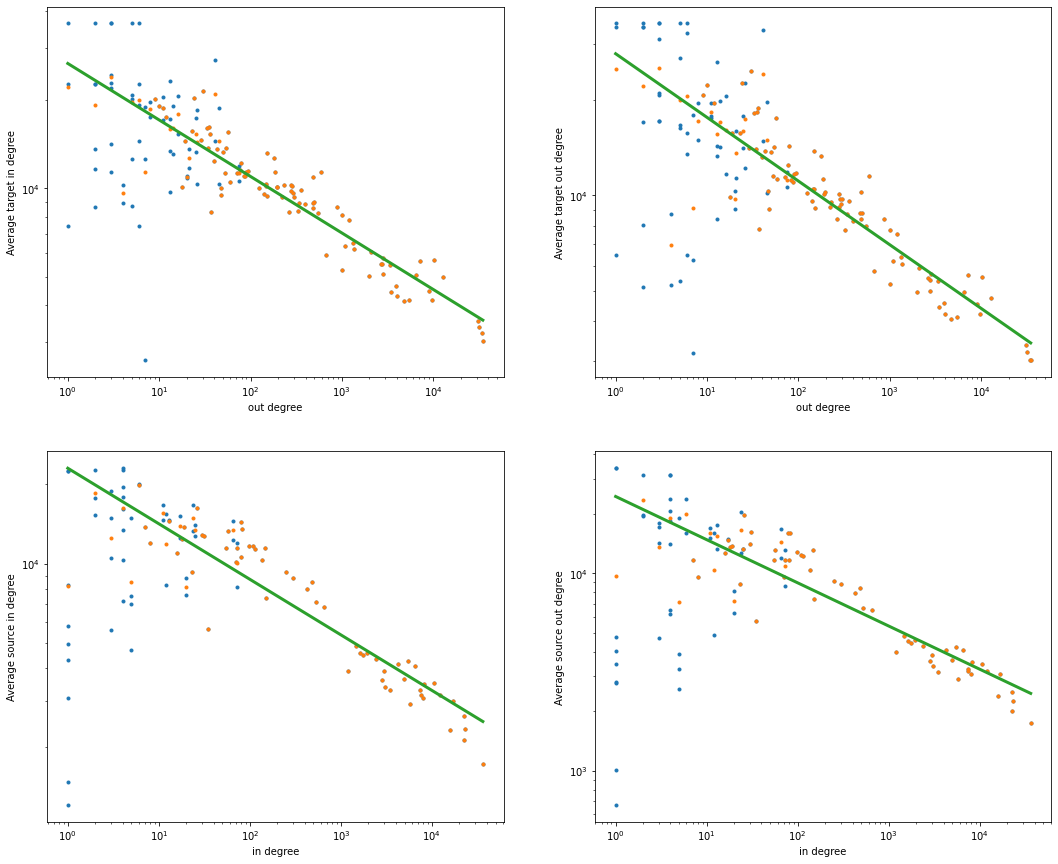

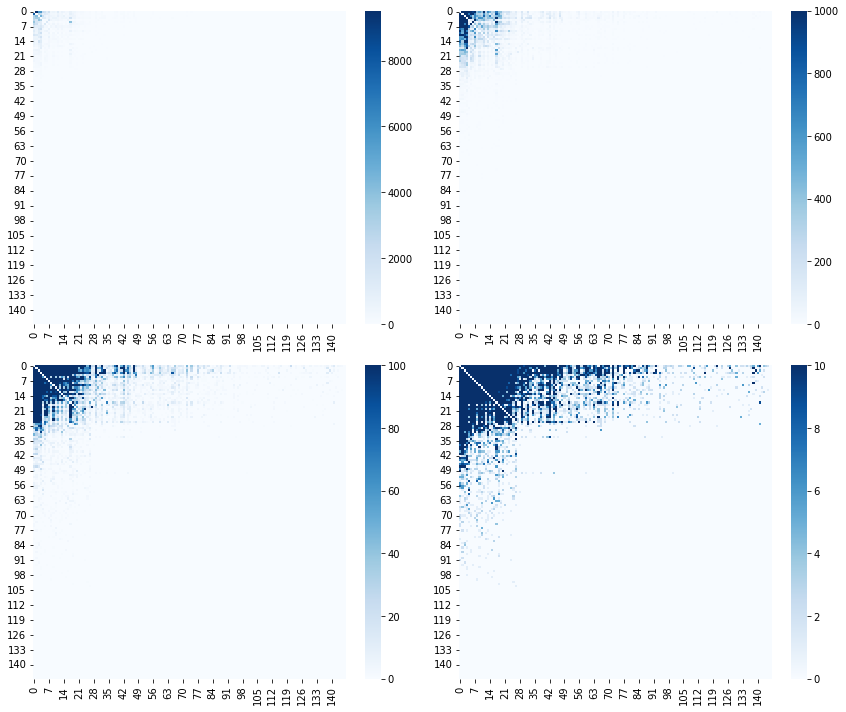

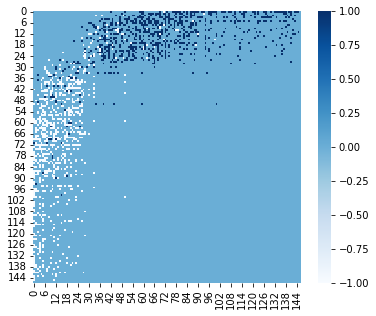

In [13]:
country19_df = pd.read_csv('data\Erasmus19.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country19_df)

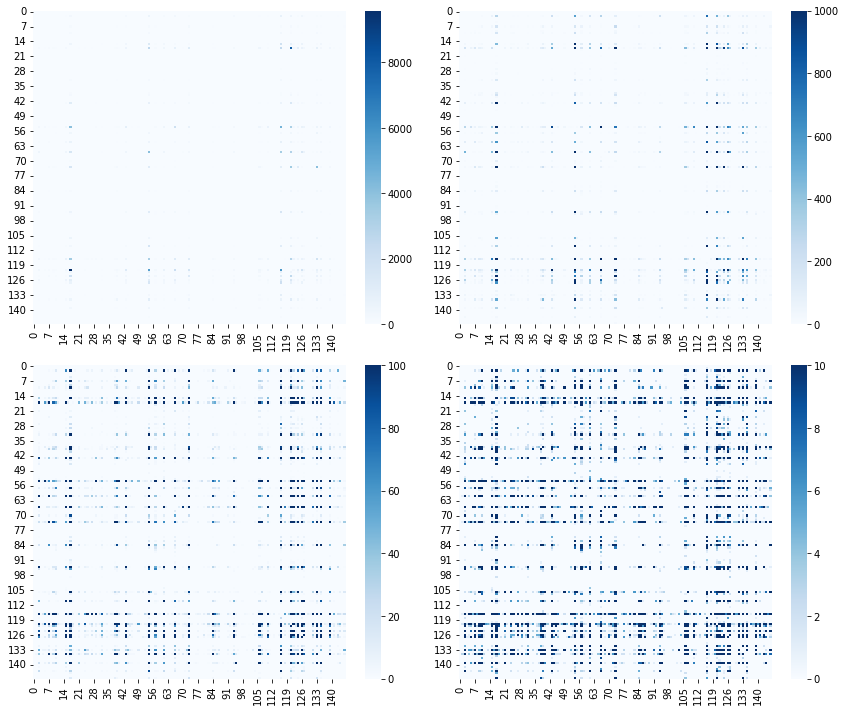

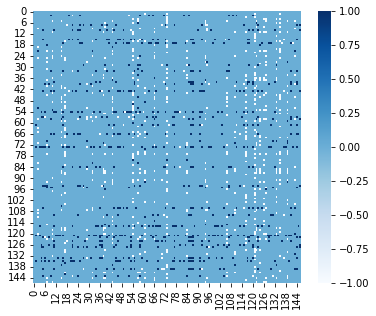

Number of components = 2


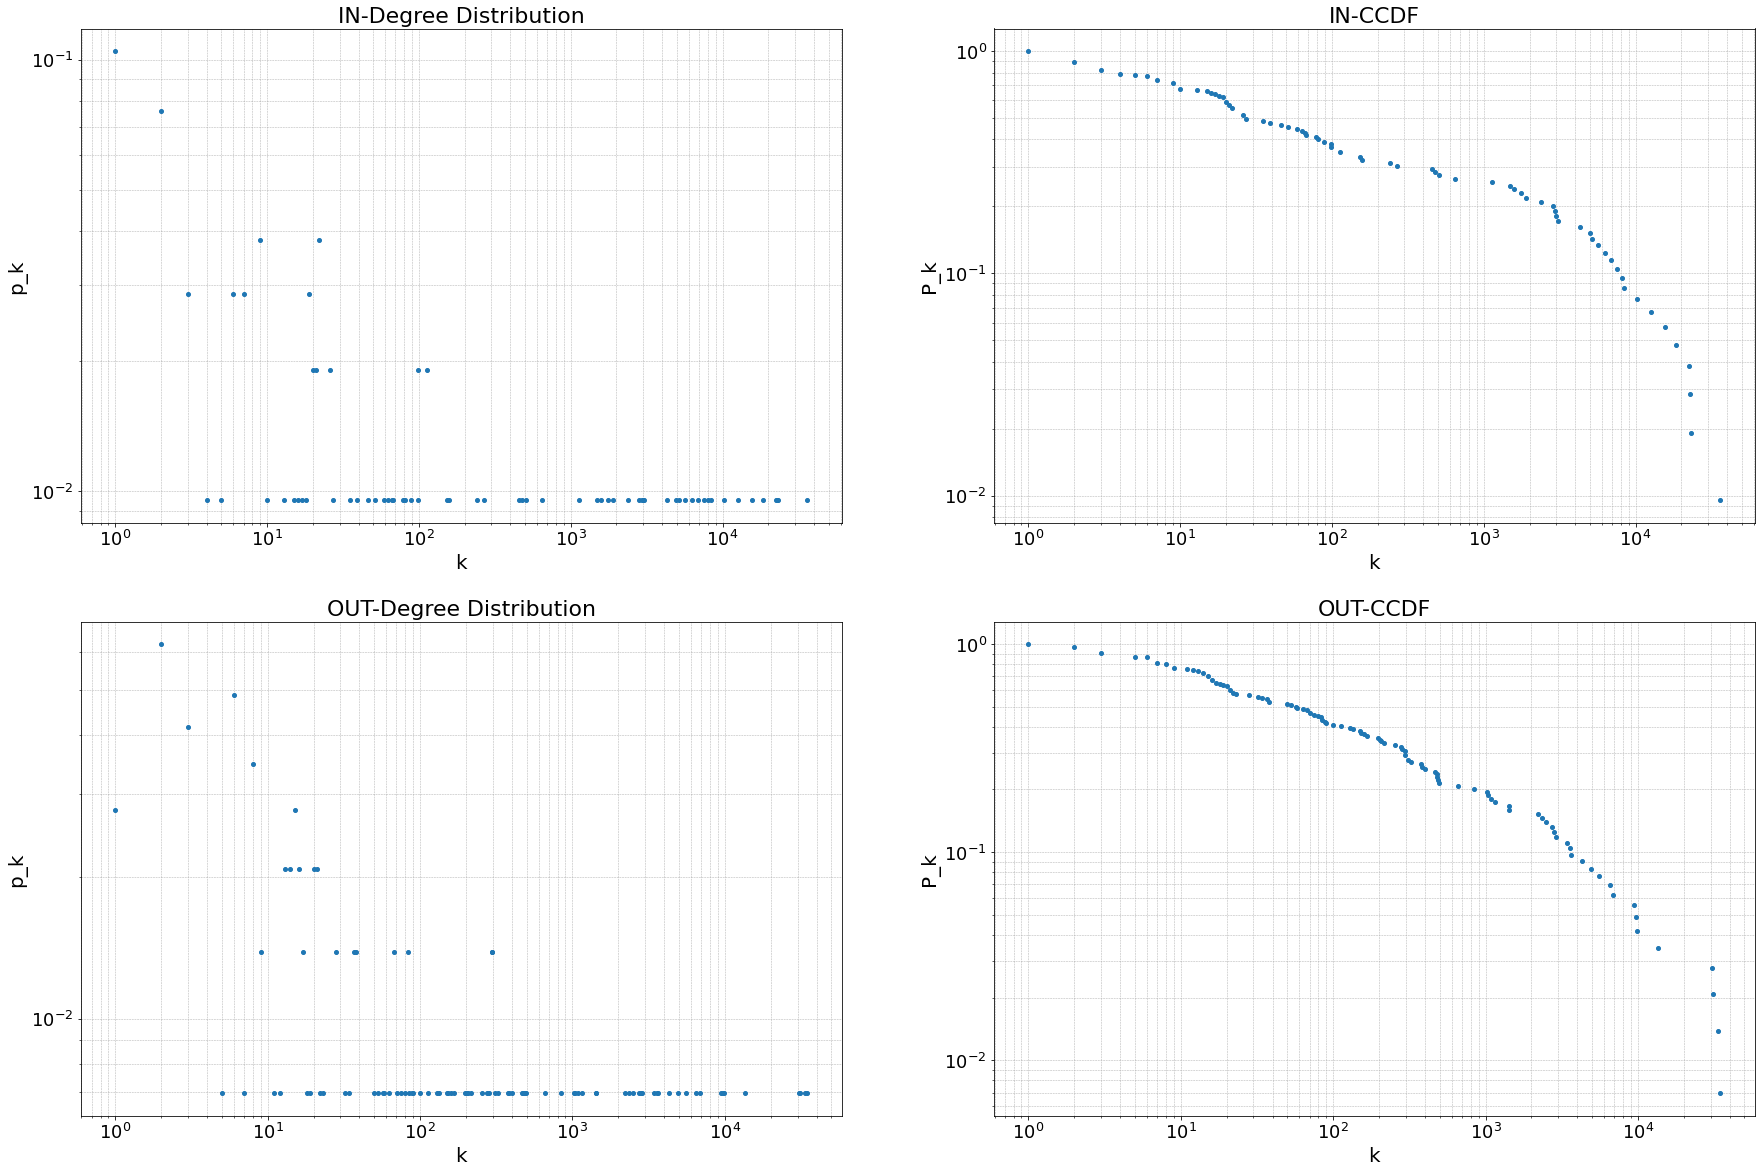

Top 10 for in degree


Nodes  in degree
121        Spain      36020
54        France      23047
116      Germany      22906
17         Italy      22627
66            UK      18474
73        Poland      15539
124     Portugal      12585
126  Netherlands      10198
135      Czechia       8342
127       Sweden       8079

Top 10 for out degree


Nodes  out degree
121        Spain       34630
116      Germany       33780
17         Italy       30947
54        France       30554
133       Turkey       13510
126  Netherlands        9843
73        Poland        9775
66            UK        9395
124     Portugal        6862
43       Belgium        6511

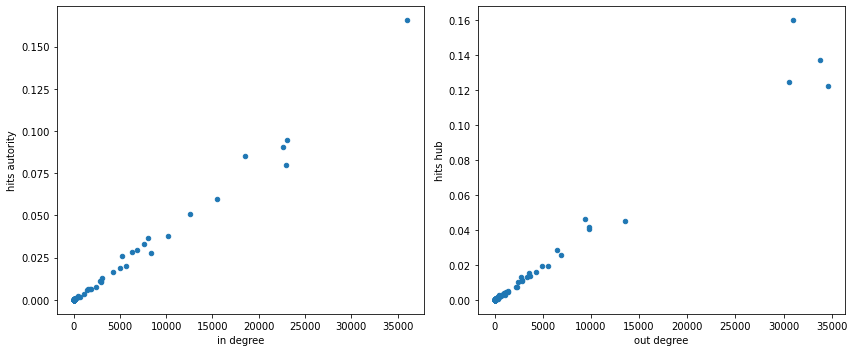

Top 10 for hits hub


Nodes  hits hub
17         Italy  0.160041
116      Germany  0.137508
54        France  0.124890
121        Spain  0.122369
66            UK  0.046538
133       Turkey  0.045017
126  Netherlands  0.041869
73        Poland  0.040729
43       Belgium  0.028681
124     Portugal  0.025886

Top 10 for hits autority


Nodes  hits autority
121        Spain       0.165548
54        France       0.094907
17         Italy       0.090780
66            UK       0.085221
116      Germany       0.079958
73        Poland       0.059830
124     Portugal       0.050634
126  Netherlands       0.037921
127       Sweden       0.036803
15       Finland       0.033260

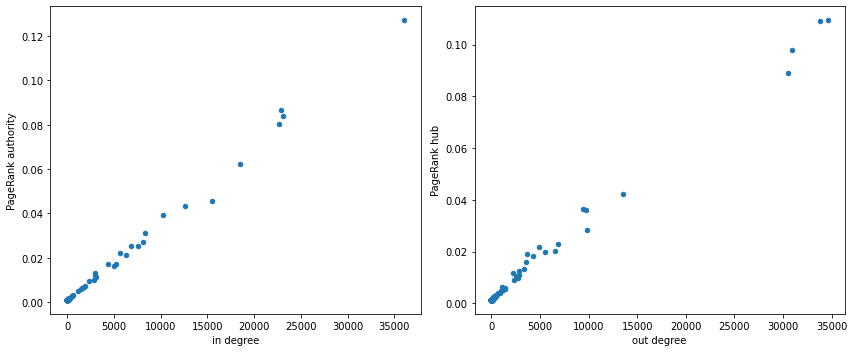

Top 10 for PageRank hub


Nodes  PageRank hub
121        Spain      0.109364
116      Germany      0.109099
17         Italy      0.097924
54        France      0.089084
133       Turkey      0.042240
66            UK      0.036373
73        Poland      0.036089
126  Netherlands      0.028372
124     Portugal      0.023053
61       Austria      0.021770

Top 10 for PageRank authority


Nodes  PageRank authority
121        Spain            0.127053
116      Germany            0.086534
54        France            0.083933
17         Italy            0.080115
66            UK            0.062336
73        Poland            0.045379
124     Portugal            0.043211
126  Netherlands            0.039211
135      Czechia            0.031170
127       Sweden            0.027315

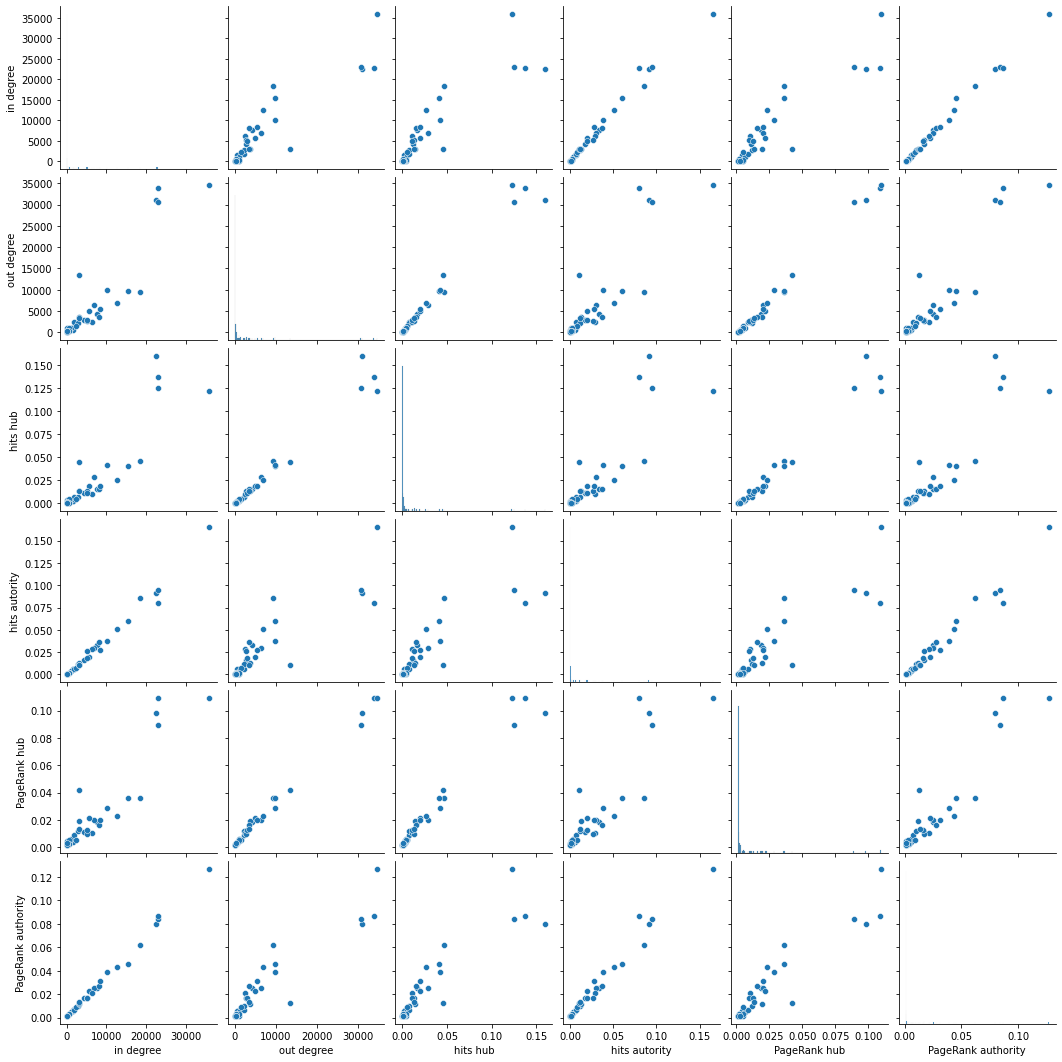

Nodes  in degree  in degree position  hits autority  \
121                   Spain      36020                   1       0.165548   
116                 Germany      22906                   3       0.079958   
54                   France      23047                   2       0.094907   
17                    Italy      22627                   4       0.090780   
66                       UK      18474                   5       0.085221   
73                   Poland      15539                   6       0.059830   
124                Portugal      12585                   7       0.050634   
126             Netherlands      10198                   8       0.037921   
135                 Czechia       8342                   9       0.027543   
127                  Sweden       8079                  10       0.036803   
15                  Finland       7590                  11       0.033260   
43                  Belgium       6846                  12       0.029684   
61                  Austria       5666                  14       0.019946   
94                   Norway       6282                  13       0.028431   
110                 Ireland       5184                  15       0.025973   
2                   Denmark       4315                  17       0.016555   
122                 Hungary       4970                  16       0.018853   
139                      EL       3001                  19       0.010903   
133                  Turkey       2952                  20       0.010592   
106                 Romania       3058                  18       0.012703   
57                Lithuania       2835                  21       0.011192   
84                 Slovenia       2378                  22       0.007568   
7                   Croatia       1909                  23       0.006136   
39                 Slovakia       1763                  24       0.006463   
10                   Latvia       1587                  25       0.006606   
32                  Estonia       1479                  26       0.005960   
38                 Bulgaria       1129                  27       0.003655   
95                   Cyprus        650                  28       0.001940   
143                 Iceland        510                  29       0.002093   
70                    Malta        453                  31       0.001687   
131      Russian Federation        475                  30       0.001612   
27                   Israel        268                  32       0.000985   
9                    Serbia        242                  33       0.000875   
82            United States        157                  34       0.000696   
29               Luxembourg        152                  35       0.000693   
24   Bosnia and Herzegovina        113                  37       0.000367   
21                    China         79                  43       0.000147   
31                   Canada         89                  41       0.000308   
107                 Ukraine         98                  40       0.000297   
146         North Macedonia        113                  36       0.000405   

     hits autority position  PageRank authority  PageRank authority position  
121                       1            0.127053                            1  
116                       5            0.086534                            2  
54                        2            0.083933                            3  
17                        3            0.080115                            4  
66                        4            0.062336                            5  
73                        6            0.045379                            6  
124                       7            0.043211                            7  
126                       8            0.039211                            8  
135                      13            0.031170                            9  
127                       9            0.027315                           

Nodes  out degree  out degree position  hits hub  \
121                   Spain       34630                    1  0.122369   
116                 Germany       33780                    2  0.137508   
17                    Italy       30947                    3  0.160041   
54                   France       30554                    4  0.124890   
133                  Turkey       13510                    5  0.045017   
66                       UK        9395                    8  0.046538   
73                   Poland        9775                    7  0.040729   
126             Netherlands        9843                    6  0.041869   
124                Portugal        6862                    9  0.025886   
61                  Austria        4938                   12  0.019161   
43                  Belgium        6511                   10  0.028681   
135                 Czechia        5527                   11  0.019247   
106                 Romania        3646                   14  0.013879   
15                  Finland        4275                   13  0.016044   
127                  Sweden        3574                   15  0.015303   
139                      EL        3404                   16  0.013223   
122                 Hungary        2882                   17  0.010898   
57                Lithuania        2205                   22  0.007061   
2                   Denmark        2811                   18  0.011598   
94                   Norway        2481                   20  0.010131   
110                 Ireland        2736                   19  0.013247   
39                 Slovakia        2345                   21  0.007096   
38                 Bulgaria        1085                   26  0.003823   
7                   Croatia        1435                   23  0.005140   
10                   Latvia        1041                   27  0.002953   
84                 Slovenia        1423                   24  0.004711   
131      Russian Federation        1158                   25  0.004444   
107                 Ukraine        1026                   28  0.003747   
32                  Estonia         660                   30  0.002223   
9                    Serbia         839                   29  0.003316   
24   Bosnia and Herzegovina         477                   34  0.001881   
40                  Morocco         489                   32  0.002320   
29               Luxembourg         495                   31  0.002038   
5                   Tunisia         483                   33  0.002575   
123                 Albania         403                   36  0.001405   
85                  Georgia         465                   35  0.001763   
146         North Macedonia         323                   39  0.000654   
27                   Israel         375                   38  0.001396   
21                    China         382                   37  0.001375   
25                       XK         277                   46  0.000855   

     hits hub position  PageRank hub  PageRank hub position  
121                  4      0.109364                      1  
116                  2      0.109099                      2  
17                   1      0.097924                      3  
54                   3      0.089084                      4  
133                  6      0.042240                      5  
66                   5      0.036373                      6  
73                   8      0.036089                      7  
126                  7      0.028372                      8  
124                 10      0.023053                      9  
61                  12      0.021770                     10  
43                   9      0.020250                     11  
135                 11      0.019907                     12  
106                 15      0.019066                     13  
15                  13      0.018470                     14  
127                 14      0.016030                     

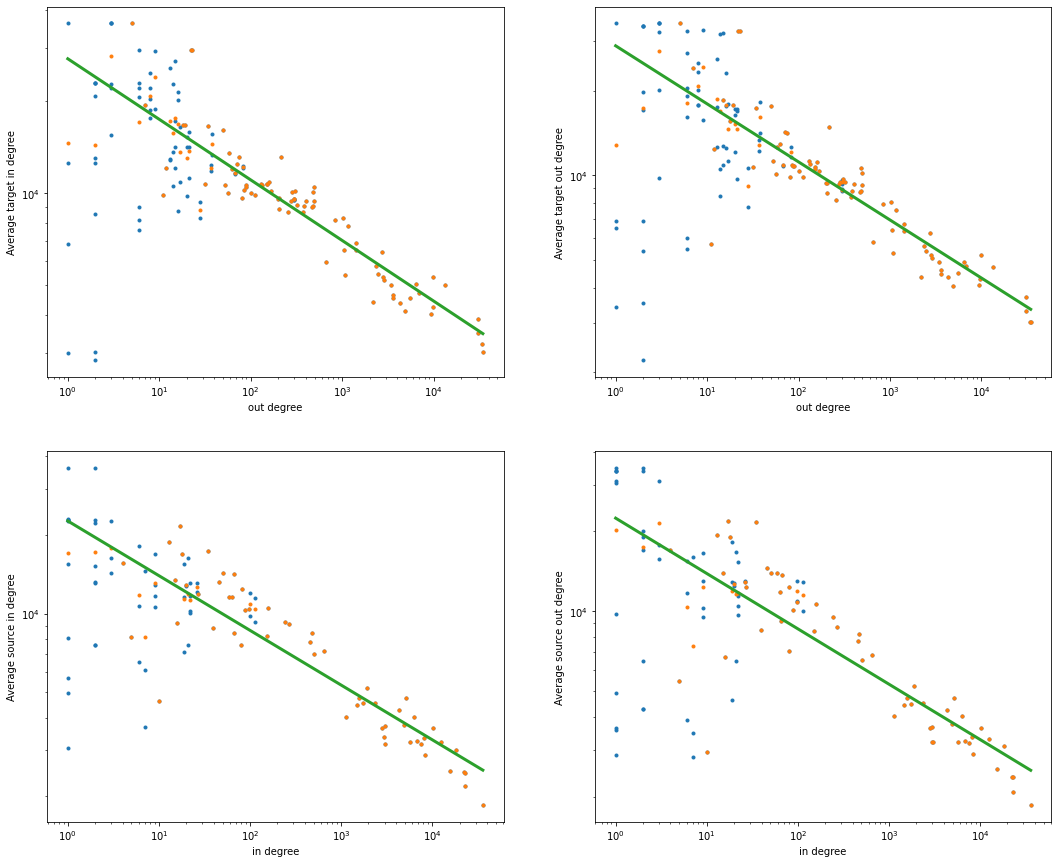

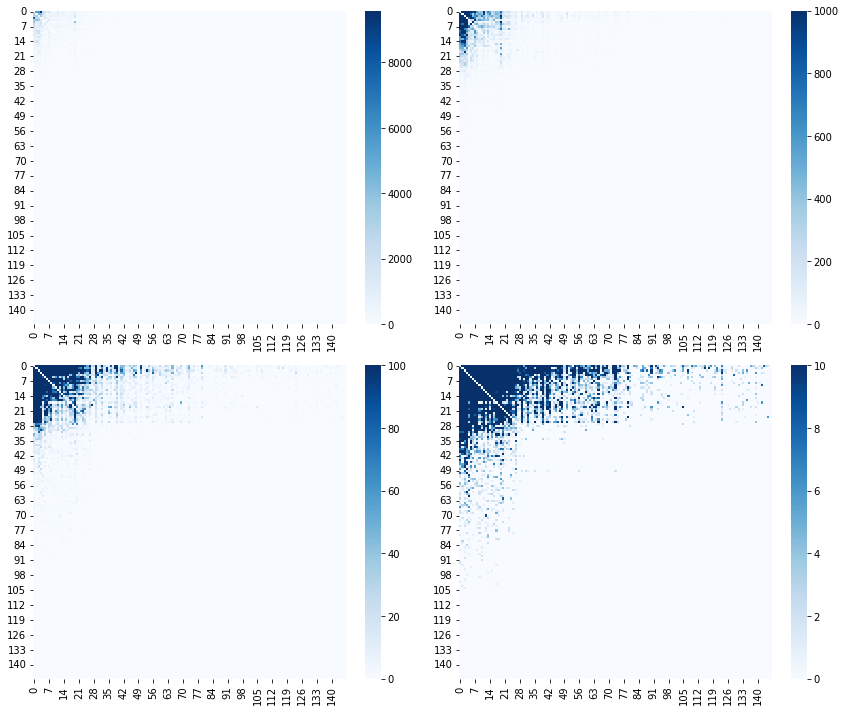

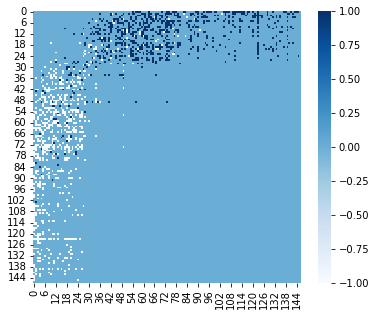

In [14]:
country18_df = pd.read_csv('data\Erasmus18.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country18_df)

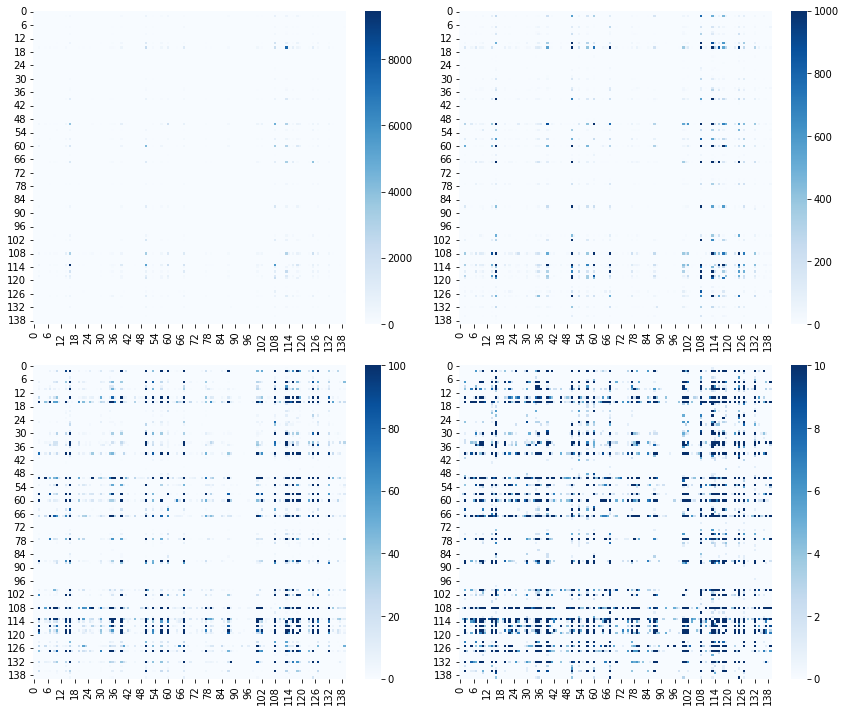

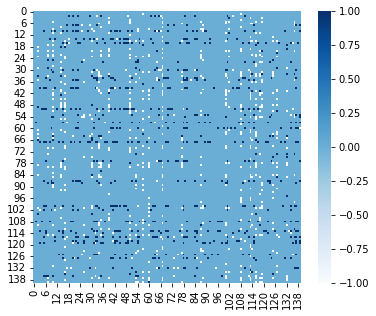

Number of components = 2


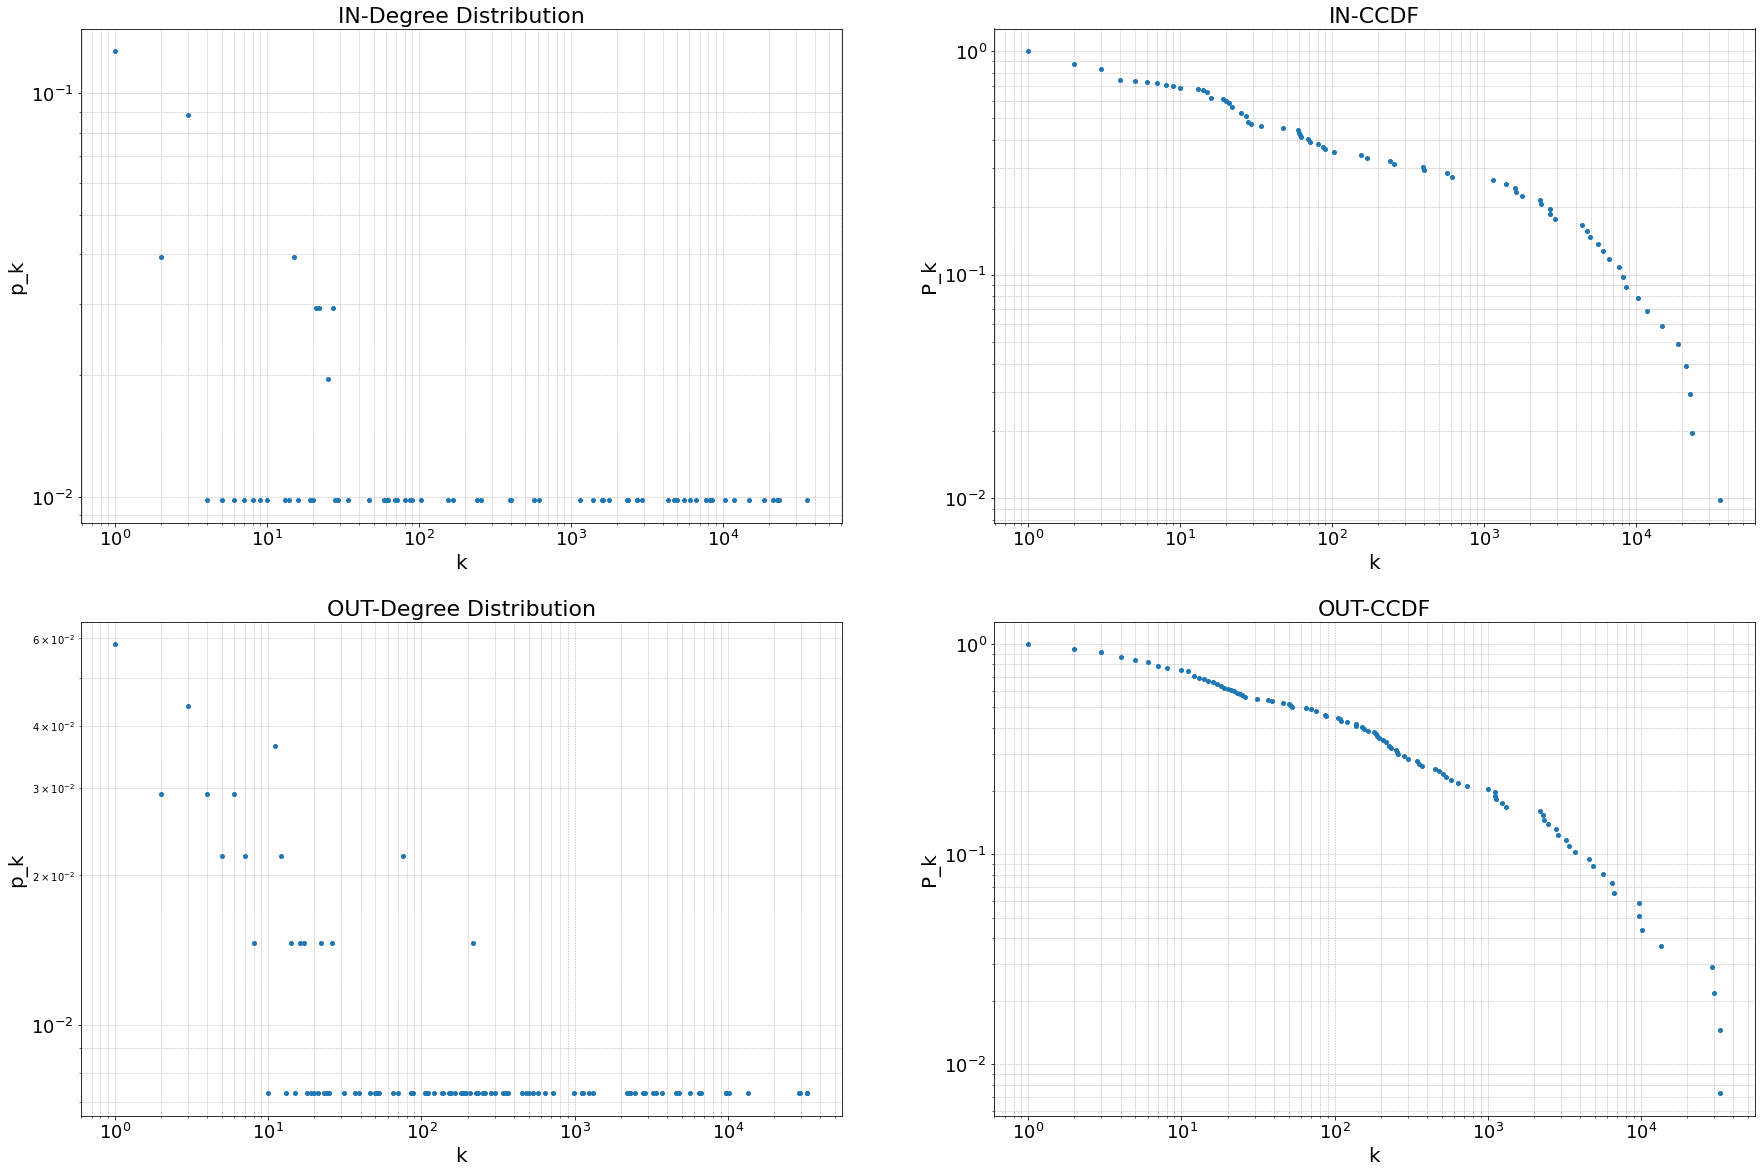

Top 10 for in degree


Nodes  in degree
113        Spain      35605
108      Germany      23161
50        France      22577
16         Italy      21364
60            UK      18668
67        Poland      14837
116     Portugal      11764
118  Netherlands      10325
119       Sweden       8497
127      Czechia       8191

Top 10 for out degree


Nodes  out degree
113        Spain       32975
108      Germany       32916
50        France       29867
16         Italy       29261
125       Turkey       13546
67        Poland       10157
118  Netherlands        9806
60            UK        9681
39       Belgium        6723
116     Portugal        6520

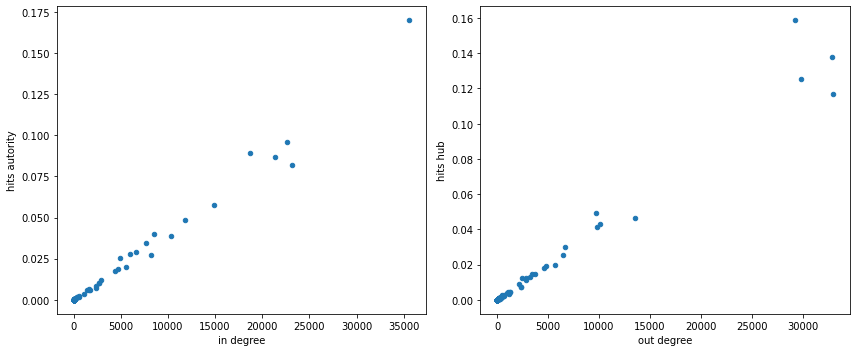

Top 10 for hits hub


Nodes  hits hub
16         Italy  0.158669
108      Germany  0.138050
50        France  0.125551
113        Spain  0.117020
60            UK  0.049037
125       Turkey  0.046440
67        Poland  0.042947
118  Netherlands  0.041421
39       Belgium  0.030267
116     Portugal  0.025288

Top 10 for hits autority


Nodes  hits autority
113        Spain       0.169761
50        France       0.095757
60            UK       0.088944
16         Italy       0.086551
108      Germany       0.082129
67        Poland       0.057782
116     Portugal       0.048229
119       Sweden       0.040013
118  Netherlands       0.039021
14       Finland       0.034659

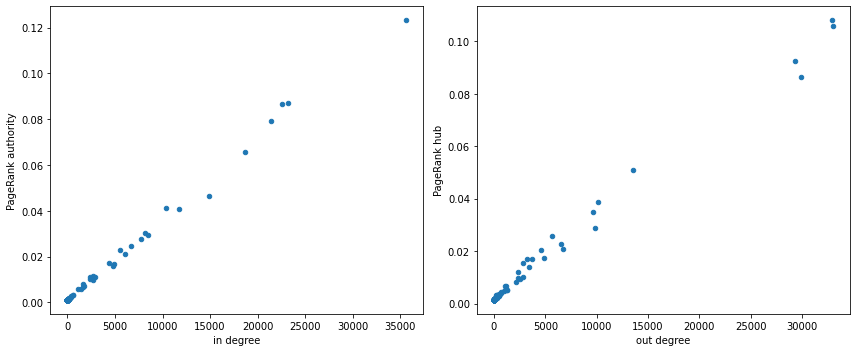

Top 10 for PageRank hub


Nodes  PageRank hub
108      Germany      0.107969
113        Spain      0.105780
16         Italy      0.092630
50        France      0.086511
125       Turkey      0.050982
67        Poland      0.038558
60            UK      0.034877
118  Netherlands      0.028793
127      Czechia      0.025774
116     Portugal      0.022677

Top 10 for PageRank authority


Nodes  PageRank authority
113        Spain            0.123114
108      Germany            0.087006
50        France            0.086449
16         Italy            0.079213
60            UK            0.065609
67        Poland            0.046248
118  Netherlands            0.041350
116     Portugal            0.040707
127      Czechia            0.030310
119       Sweden            0.029418

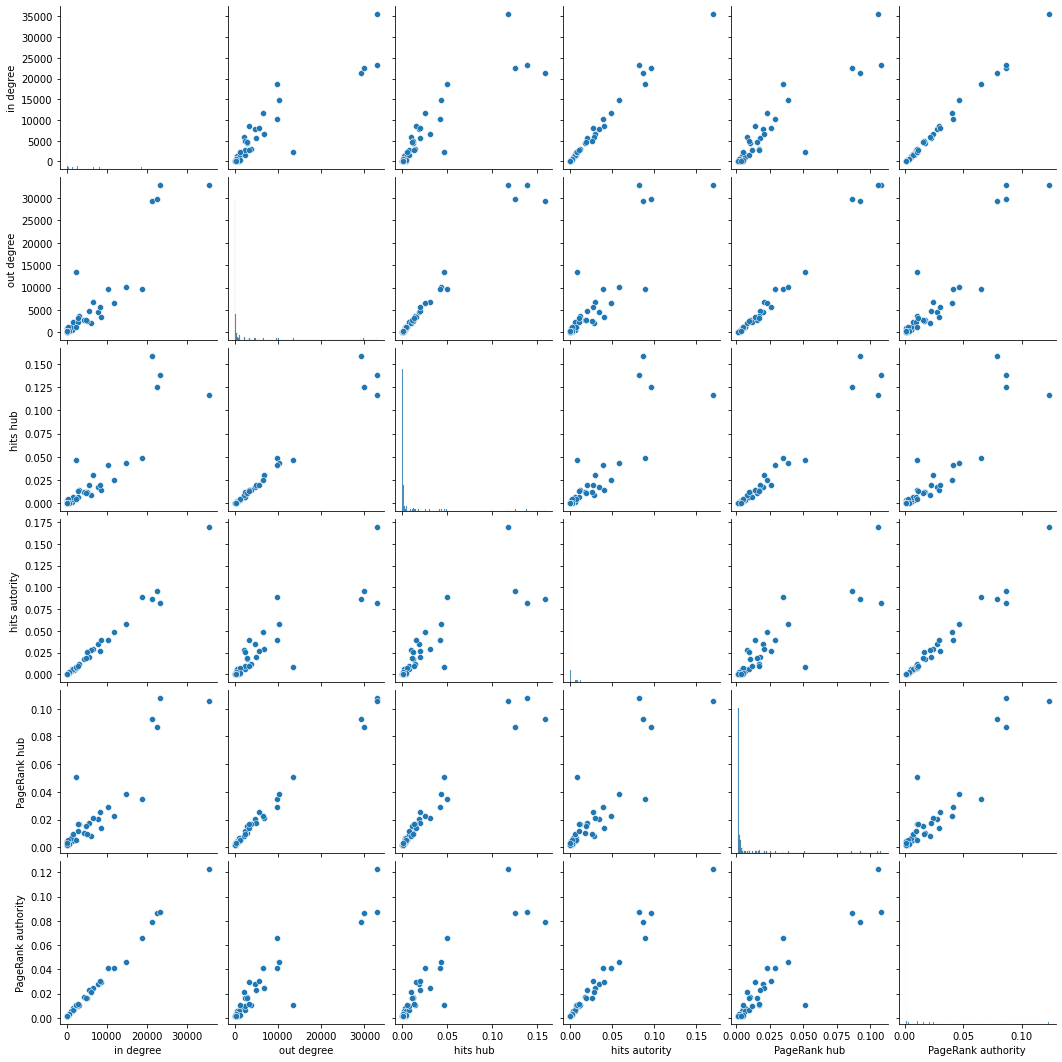

Nodes  in degree  in degree position  hits autority  \
113               Spain      35605                   1       0.169761   
108             Germany      23161                   2       0.082129   
50               France      22577                   3       0.095757   
16                Italy      21364                   4       0.086551   
60                   UK      18668                   5       0.088944   
67               Poland      14837                   6       0.057782   
118         Netherlands      10325                   8       0.039021   
116            Portugal      11764                   7       0.048229   
127             Czechia       8191                  10       0.027478   
119              Sweden       8497                   9       0.040013   
14              Finland       7719                  11       0.034659   
39              Belgium       6645                  12       0.029181   
57              Austria       5562                  14       0.020000   
87               Norway       6012                  13       0.027800   
2               Denmark       4362                  17       0.017367   
102             Ireland       4942                  15       0.025519   
114             Hungary       4753                  16       0.018594   
132                  EL       2688                  20       0.009944   
100             Romania       2932                  18       0.011985   
125              Turkey       2326                  22       0.008511   
77             Slovenia       2367                  21       0.007317   
53            Lithuania       2692                  19       0.010274   
10               Latvia       1593                  25       0.006580   
7               Croatia       1777                  23       0.005673   
35             Slovakia       1627                  24       0.006065   
30              Estonia       1397                  26       0.005867   
34             Bulgaria       1142                  27       0.003644   
136             Iceland        569                  29       0.002494   
88               Cyprus        614                  28       0.001771   
64                Malta        395                  31       0.001552   
123  Russian Federation        403                  30       0.001586   
25               Israel        240                  33       0.000845   
9                Serbia        253                  32       0.000888   
75        United States        168                  34       0.000569   
26           Luxembourg        154                  35       0.000767   
20                China         87                  38       0.000229   
29               Canada        102                  36       0.000447   
66                Japan         90                  37       0.000415   
17   Korea, Republic of         59                  45       0.000186   
115             Albania         71                  40       0.000381   

     hits autority position  PageRank authority  PageRank authority position  
113                       1            0.123114                            1  
108                       5            0.087006                            2  
50                        2            0.086449                            3  
16                        4            0.079213                            4  
60                        3            0.065609                            5  
67                        6            0.046248                            6  
118                       9            0.041350                            7  
116                       7            0.040707                            8  
127                      13            0.030310                            9  
119                       8            0.029418                           10  
14                       10            0.027783                           11  
39                       11            0.024593                           12

Nodes  out degree  out degree position  hits hub  \
108                 Germany       32916                    2  0.138050   
113                   Spain       32975                    1  0.117020   
16                    Italy       29261                    4  0.158669   
50                   France       29867                    3  0.125551   
125                  Turkey       13546                    5  0.046440   
67                   Poland       10157                    6  0.042947   
60                       UK        9681                    8  0.049037   
118             Netherlands        9806                    7  0.041421   
127                 Czechia        5694                   11  0.019911   
116                Portugal        6520                   10  0.025288   
39                  Belgium        6723                    9  0.030267   
14                  Finland        4613                   13  0.018064   
57                  Austria        4838                   12  0.019445   
100                 Romania        3701                   14  0.014400   
132                      EL        3268                   16  0.013178   
114                 Hungary        2869                   17  0.011019   
119                  Sweden        3394                   15  0.014861   
53                Lithuania        2309                   21  0.007263   
2                   Denmark        2810                   18  0.012119   
35                 Slovakia        2316                   20  0.007171   
102                 Ireland        2492                   19  0.012187   
87                   Norway        2196                   22  0.009252   
34                 Bulgaria        1112                   27  0.003873   
10                   Latvia        1141                   25  0.003331   
77                 Slovenia        1311                   23  0.004607   
7                   Croatia        1233                   24  0.004574   
123      Russian Federation        1122                   26  0.004397   
101                 Ukraine         998                   28  0.004001   
30                  Estonia         643                   30  0.002034   
9                    Serbia         728                   29  0.002768   
22   Bosnia and Herzegovina         450                   35  0.001515   
20                    China         575                   31  0.002390   
36                  Morocco         537                   32  0.002809   
79                  Georgia         507                   33  0.001899   
139         North Macedonia         303                   39  0.000562   
40                   Jordan         259                   41  0.000759   
65               Azerbaijan         189                   50  0.000450   
26               Luxembourg         484                   34  0.002201   
5                   Tunisia         357                   37  0.001660   
115                 Albania         370                   36  0.001528   

     hits hub position  PageRank hub  PageRank hub position  
108                  2      0.107969                      1  
113                  4      0.105780                      2  
16                   1      0.092630                      3  
50                   3      0.086511                      4  
125                  6      0.050982                      5  
67                   7      0.038558                      6  
60                   5      0.034877                      7  
118                  8      0.028793                      8  
127                 11      0.025774                      9  
116                 10      0.022677                     10  
39                   9      0.020963                     11  
14                  13      0.020220                     12  
57                  12      0.017531                     13  
100                 15      0.017118                     14  
132                 16      0.016792                     

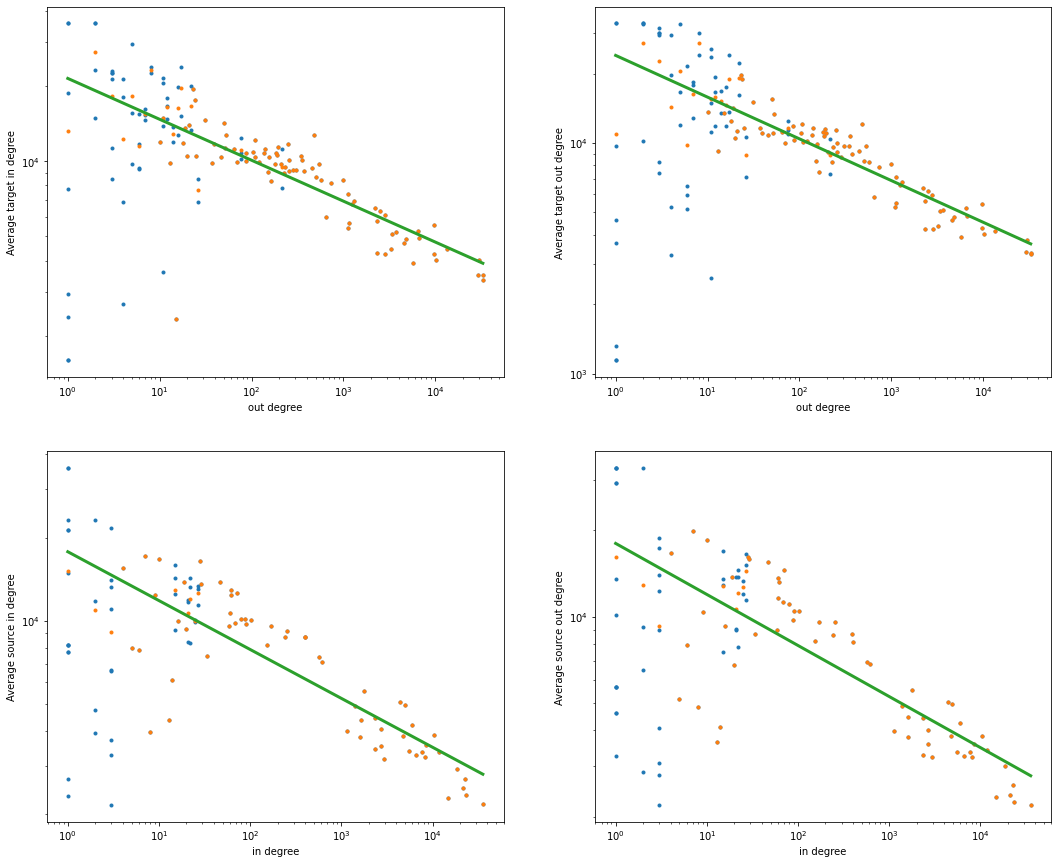

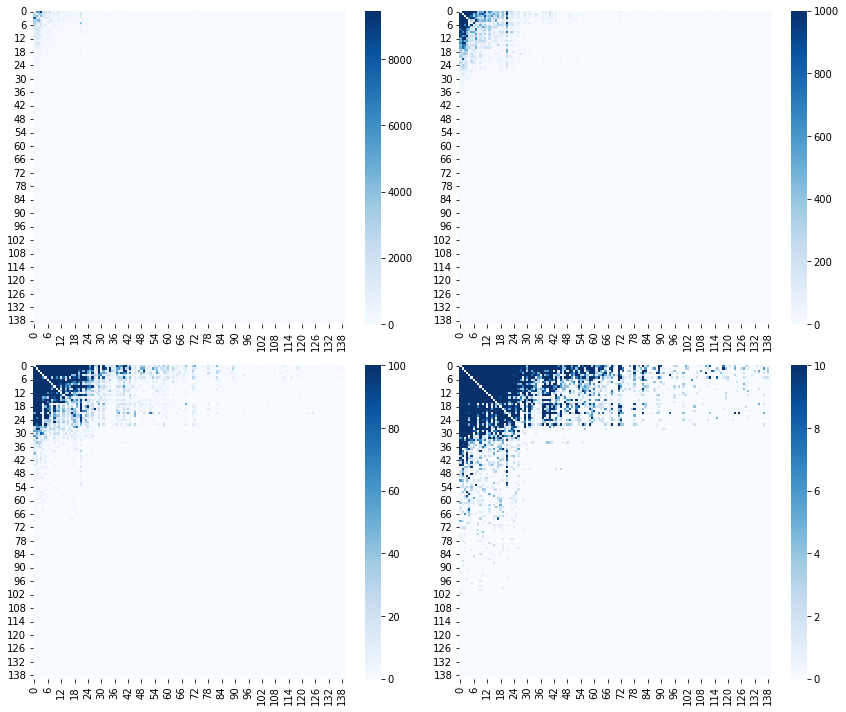

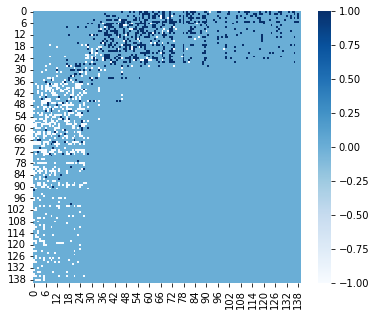

In [15]:
country17_df = pd.read_csv('data\Erasmus17.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country17_df)

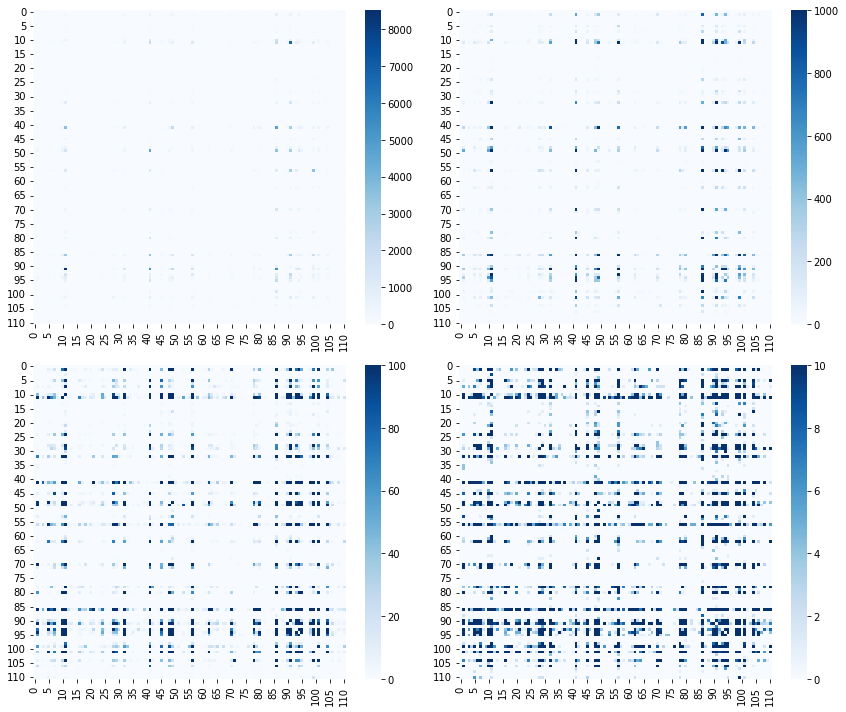

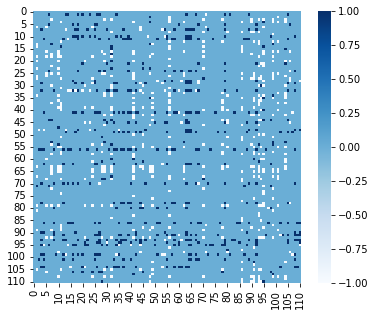

Number of components = 2


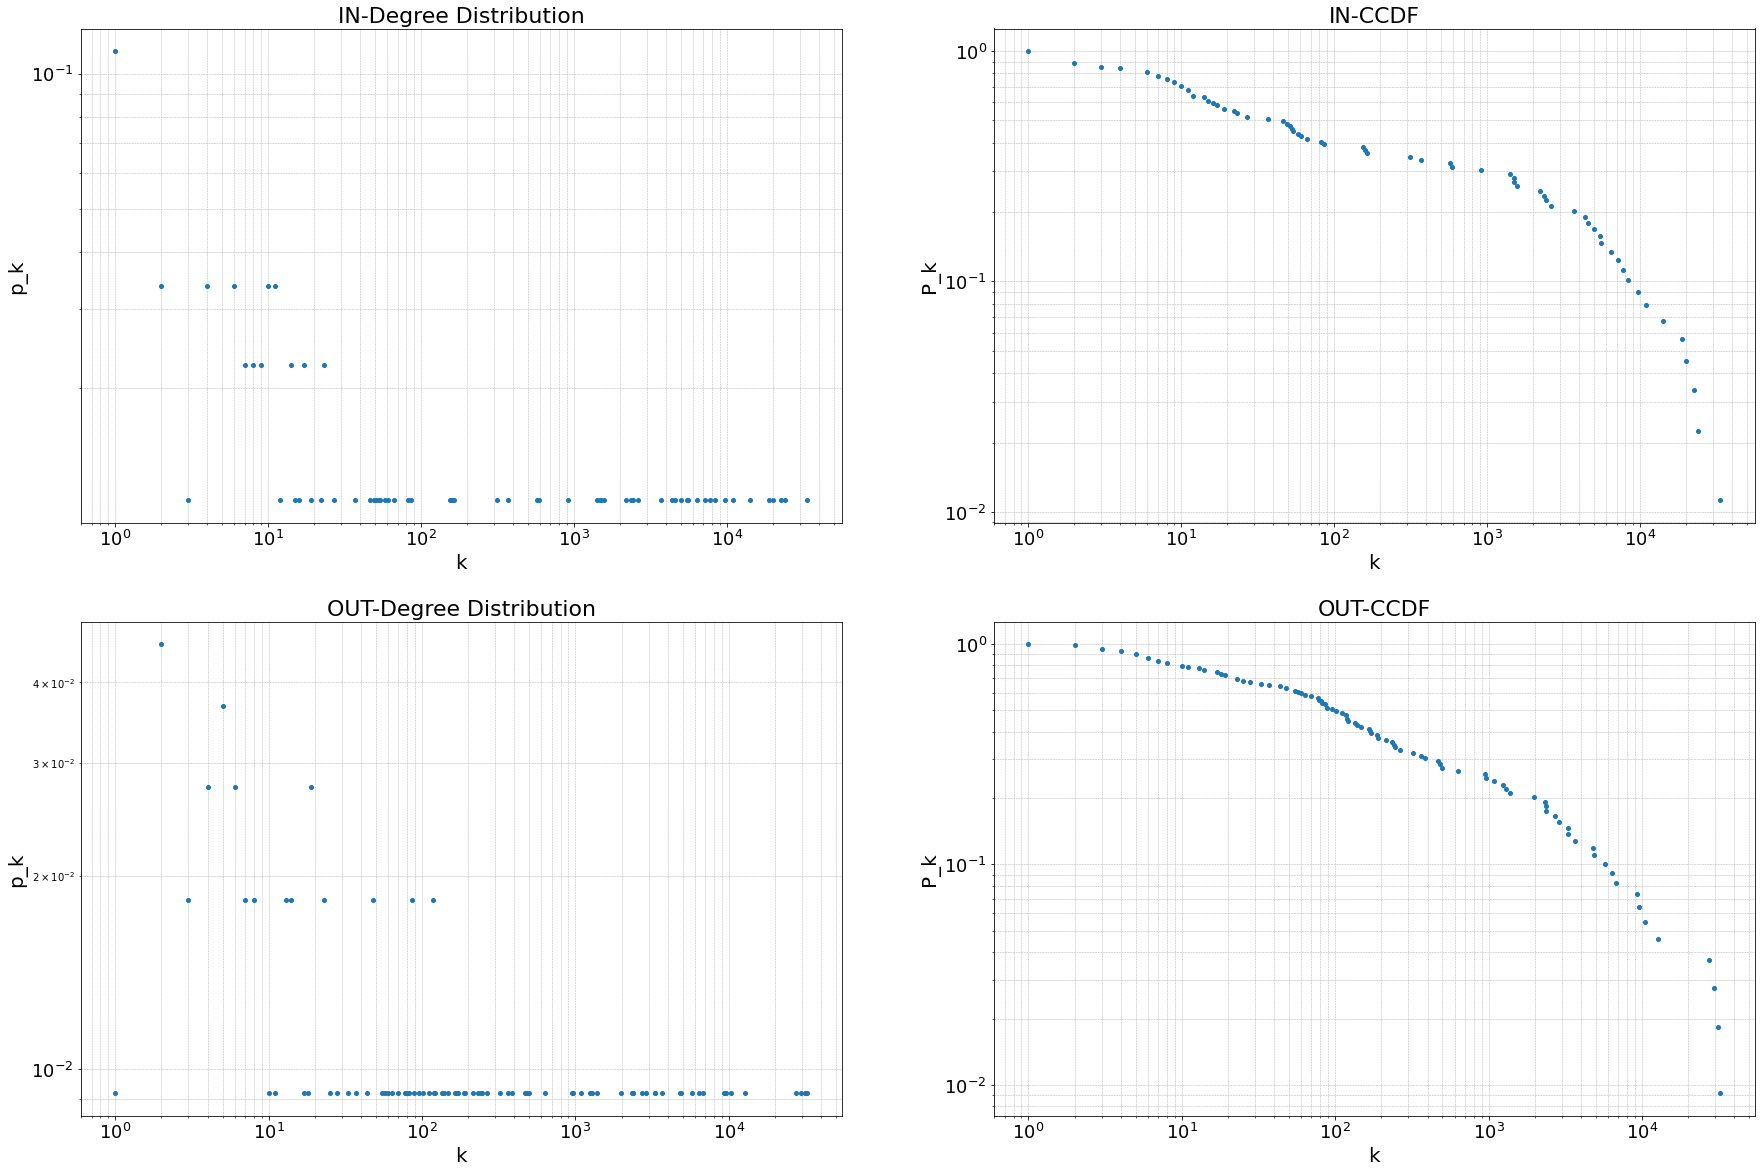

Top 10 for in degree


Nodes  in degree
91         Spain      33293
86       Germany      23798
41        France      22383
11         Italy      19833
49            UK      18794
56        Poland      14105
93      Portugal      10852
94   Netherlands       9731
95        Sweden       8345
101      Czechia       7736

Top 10 for out degree


Nodes  out degree
86      Germany       32334
91        Spain       31506
41       France       29317
11        Italy       27270
99       Turkey       12785
56       Poland       10401
49           UK        9578
94  Netherlands        9319
32      Belgium        6751
93     Portugal        6377

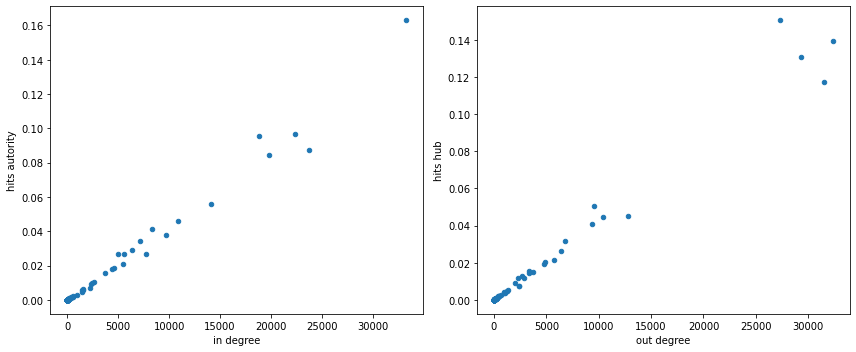

Top 10 for hits hub


Nodes  hits hub
11        Italy  0.150597
86      Germany  0.139633
41       France  0.131016
91        Spain  0.117437
49           UK  0.050395
99       Turkey  0.045201
56       Poland  0.044641
94  Netherlands  0.040668
32      Belgium  0.031715
93     Portugal  0.026263

Top 10 for hits autority


Nodes  hits autority
91        Spain       0.162945
41       France       0.096727
49           UK       0.095482
86      Germany       0.087375
11        Italy       0.084303
56       Poland       0.055721
93     Portugal       0.045732
95       Sweden       0.041256
94  Netherlands       0.038033
10      Finland       0.034068

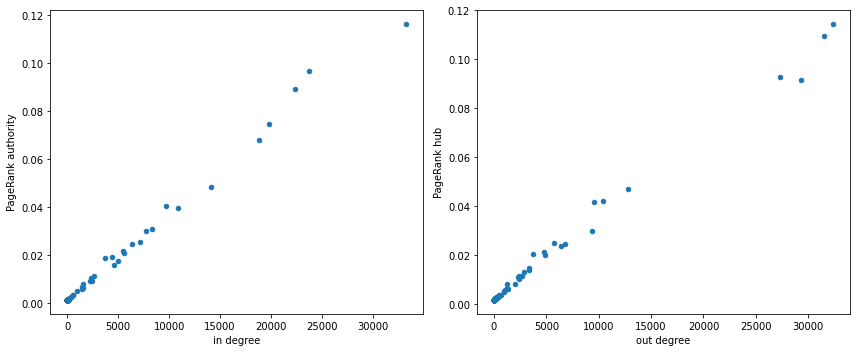

Top 10 for PageRank hub


Nodes  PageRank hub
86       Germany      0.114569
91         Spain      0.109729
11         Italy      0.092845
41        France      0.091482
99        Turkey      0.046980
56        Poland      0.042238
49            UK      0.041662
94   Netherlands      0.029906
101      Czechia      0.024756
32       Belgium      0.024384

Top 10 for PageRank authority


Nodes  PageRank authority
91         Spain            0.116533
86       Germany            0.096689
41        France            0.089403
11         Italy            0.074795
49            UK            0.068275
56        Poland            0.048501
94   Netherlands            0.040407
93      Portugal            0.039777
95        Sweden            0.030819
101      Czechia            0.029999

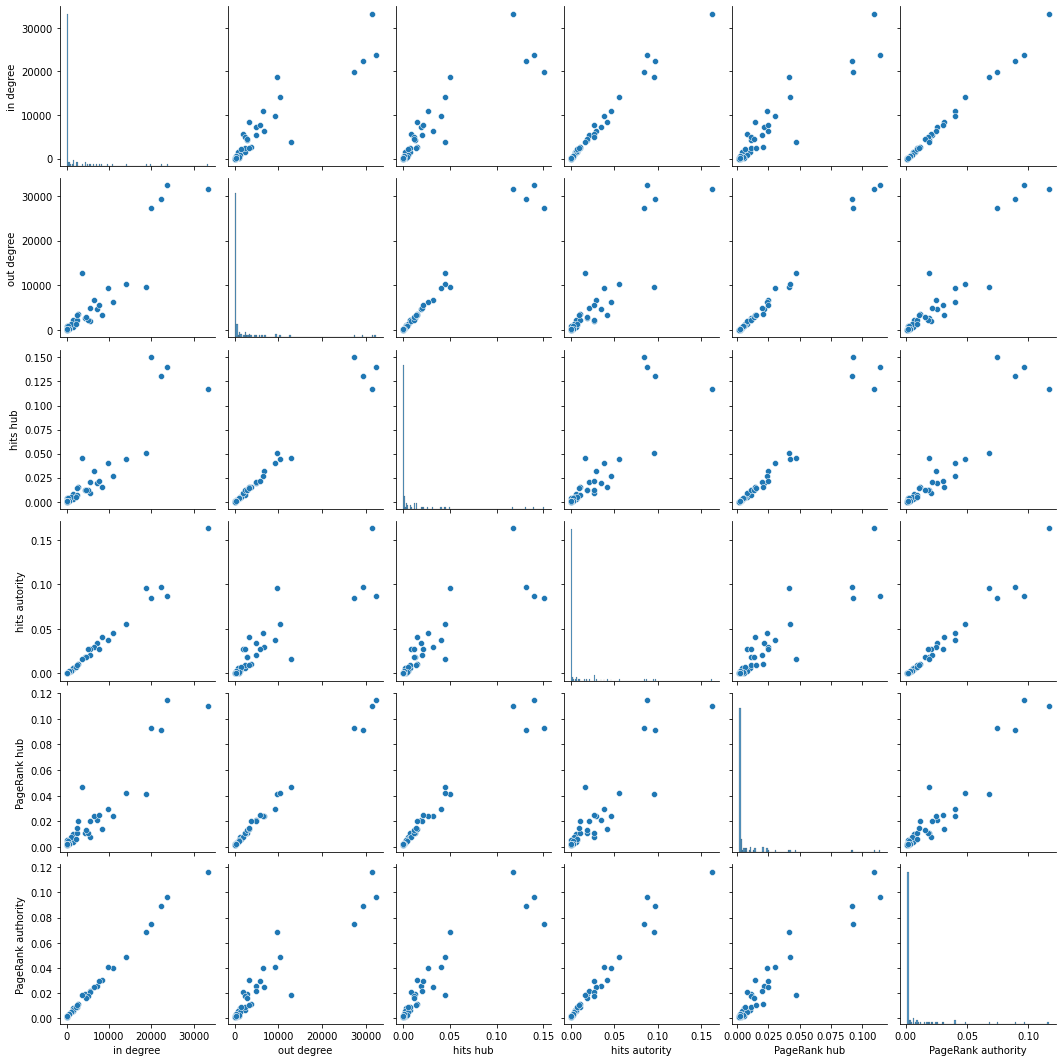

Nodes  in degree  in degree position  hits autority  \
91                Spain      33293                   1       0.162945   
86              Germany      23798                   2       0.087375   
41               France      22383                   3       0.096727   
11                Italy      19833                   4       0.084303   
49                   UK      18794                   5       0.095482   
56               Poland      14105                   6       0.055721   
94          Netherlands       9731                   8       0.038033   
93             Portugal      10852                   7       0.045732   
95               Sweden       8345                   9       0.041256   
101             Czechia       7736                  10       0.026969   
10              Finland       7179                  11       0.034068   
32              Belgium       6395                  12       0.029199   
48              Austria       5428                  14       0.020758   
70               Norway       5532                  13       0.026885   
1               Denmark       4341                  17       0.017851   
99               Turkey       3693                  18       0.015895   
80              Ireland       4999                  15       0.026967   
90              Hungary       4542                  16       0.018515   
78              Romania       2625                  19       0.010639   
104                  EL       2353                  21       0.008945   
62             Slovenia       2196                  22       0.006885   
45            Lithuania       2429                  20       0.009774   
7                Latvia       1500                  24       0.006364   
5               Croatia       1485                  25       0.004798   
28             Slovakia       1556                  23       0.005946   
24              Estonia       1408                  26       0.005928   
29             Bulgaria        916                  27       0.003091   
106             Iceland        586                  28       0.002462   
71               Cyprus        570                  29       0.001849   
53                Malta        311                  31       0.001155   
98   Russian Federation        368                  30       0.001684   
61        United States        159                  33       0.000595   
6                Serbia        163                  32       0.000558   
21           Luxembourg        155                  34       0.000800   
20               Israel         82                  36       0.000308   
23               Canada         86                  35       0.000393   
16                China         66                  37       0.000184   
60            Australia         61                  38       0.000333   
30              Morocco         58                  39       0.000304   
13   Korea, Republic of         49                  43       0.000137   

     hits autority position  PageRank authority  PageRank authority position  
91                        1            0.116533                            1  
86                        4            0.096689                            2  
41                        2            0.089403                            3  
11                        5            0.074795                            4  
49                        3            0.068275                            5  
56                        6            0.048501                            6  
94                        9            0.040407                            7  
93                        7            0.039777                            8  
95                        8            0.030819                            9  
101                      12            0.029999                           10  
10                       10            0.025510                           11  
32                       11            0.024832                           12

Nodes  out degree  out degree position  hits hub  \
86              Germany       32334                    1  0.139633   
91                Spain       31506                    2  0.117437   
11                Italy       27270                    4  0.150597   
41               France       29317                    3  0.131016   
99               Turkey       12785                    5  0.045201   
56               Poland       10401                    6  0.044641   
49                   UK        9578                    7  0.050395   
94          Netherlands        9319                    8  0.040668   
101             Czechia        5721                   11  0.021545   
32              Belgium        6751                    9  0.031715   
93             Portugal        6377                   10  0.026263   
10              Finland        4781                   13  0.019474   
78              Romania        3678                   14  0.014823   
48              Austria        4873                   12  0.020217   
104                  EL        3310                   16  0.014303   
95               Sweden        3319                   15  0.015275   
90              Hungary        2887                   17  0.011807   
45            Lithuania        2359                   20  0.007445   
1               Denmark        2720                   18  0.012691   
80              Ireland        2333                   21  0.011820   
28             Slovakia        2368                   19  0.007646   
70               Norway        1979                   22  0.008815   
29             Bulgaria        1290                   24  0.004872   
5               Croatia        1251                   25  0.004658   
62             Slovenia        1381                   23  0.005118   
7                Latvia        1085                   26  0.003462   
79              Ukraine         945                   28  0.003750   
98   Russian Federation         969                   27  0.004081   
24              Estonia         632                   29  0.002337   
6                Serbia         496                   30  0.001893   
21           Luxembourg         485                   31  0.002327   
16                China         468                   32  0.002004   
63              Georgia         361                   34  0.001258   
30              Morocco         383                   33  0.001900   
71               Cyprus         321                   35  0.000758   
65           Kazakhstan         247                   37  0.000918   
3               Tunisia         266                   36  0.001248   
110     North Macedonia         191                   41  0.000417   
92              Albania         187                   42  0.000763   
33               Jordan         148                   46  0.000516   

     hits hub position  PageRank hub  PageRank hub position  
86                   2      0.114569                      1  
91                   4      0.109729                      2  
11                   1      0.092845                      3  
41                   3      0.091482                      4  
99                   6      0.046980                      5  
56                   7      0.042238                      6  
49                   5      0.041662                      7  
94                   8      0.029906                      8  
101                 11      0.024756                      9  
32                   9      0.024384                     10  
93                  10      0.023881                     11  
10                  13      0.021154                     12  
78                  15      0.020380                     13  
48                  12      0.020145                     14  
104                 16      0.014628                     15  
95                  14      0.014002                     16  
90                  19      0.013235                     17  
45                  22      0.0

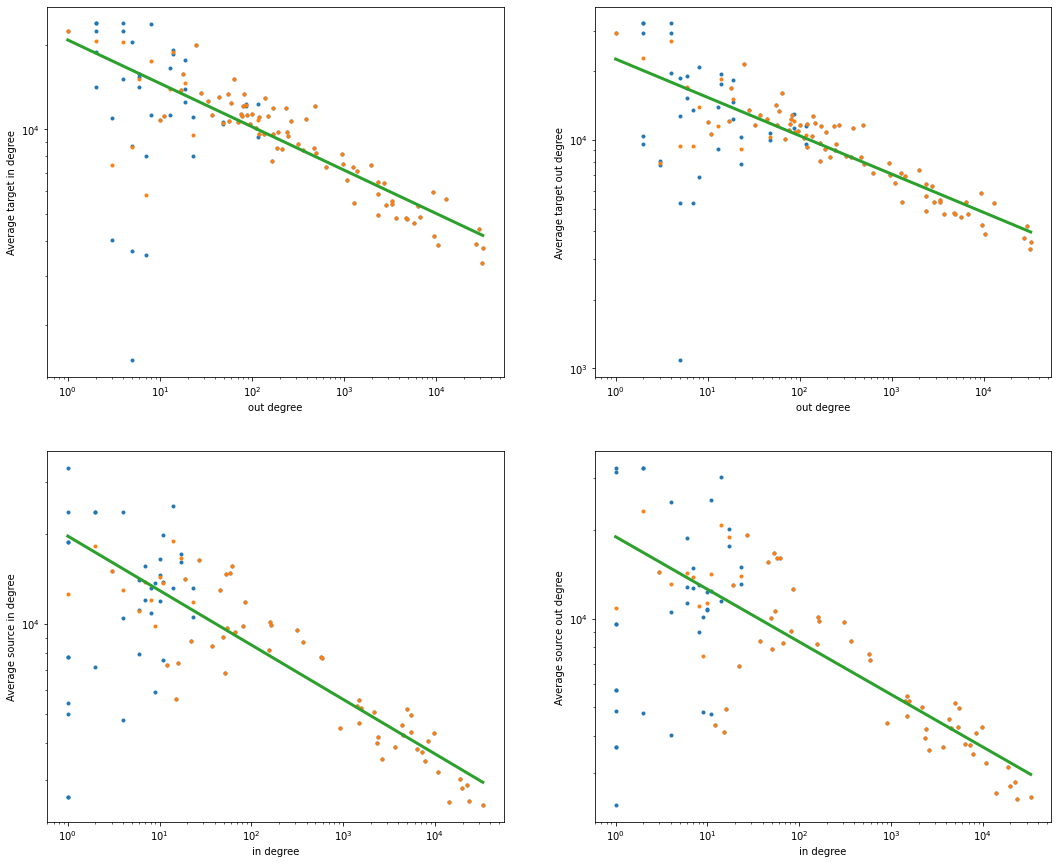

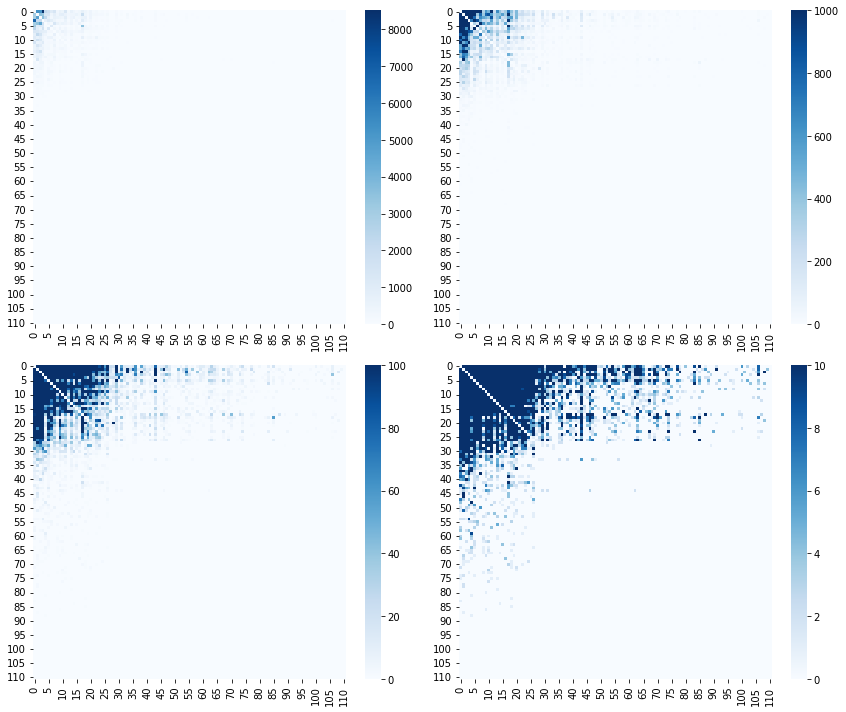

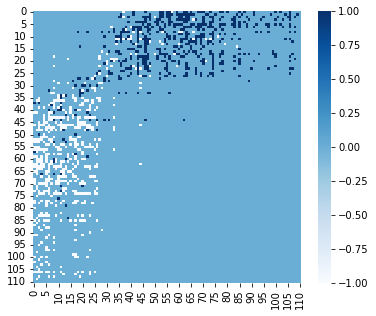

In [16]:
country16_df = pd.read_csv('data\Erasmus16.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country16_df)

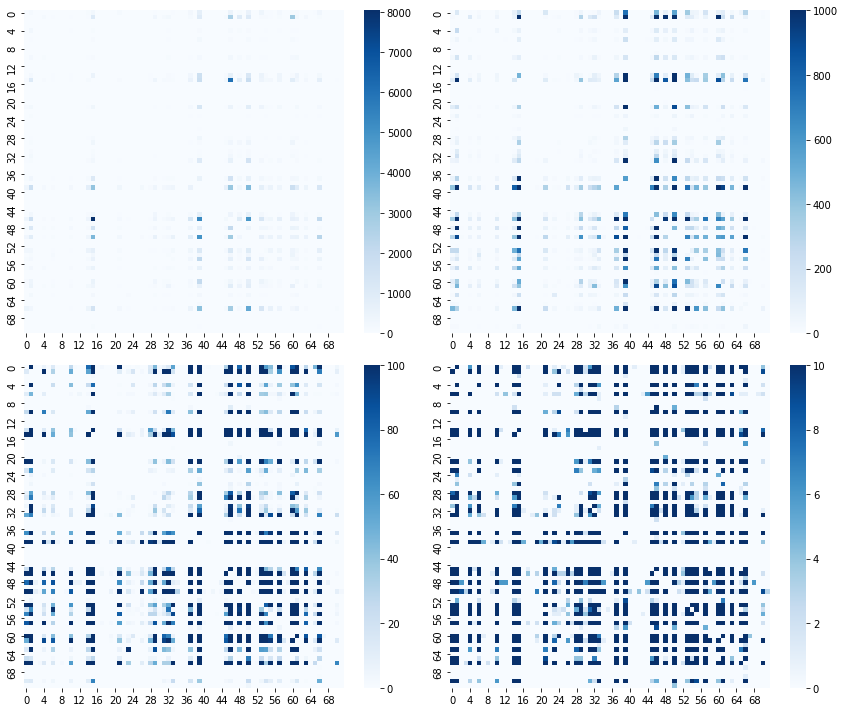

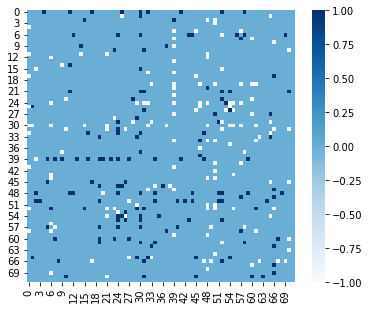

Number of components = 1


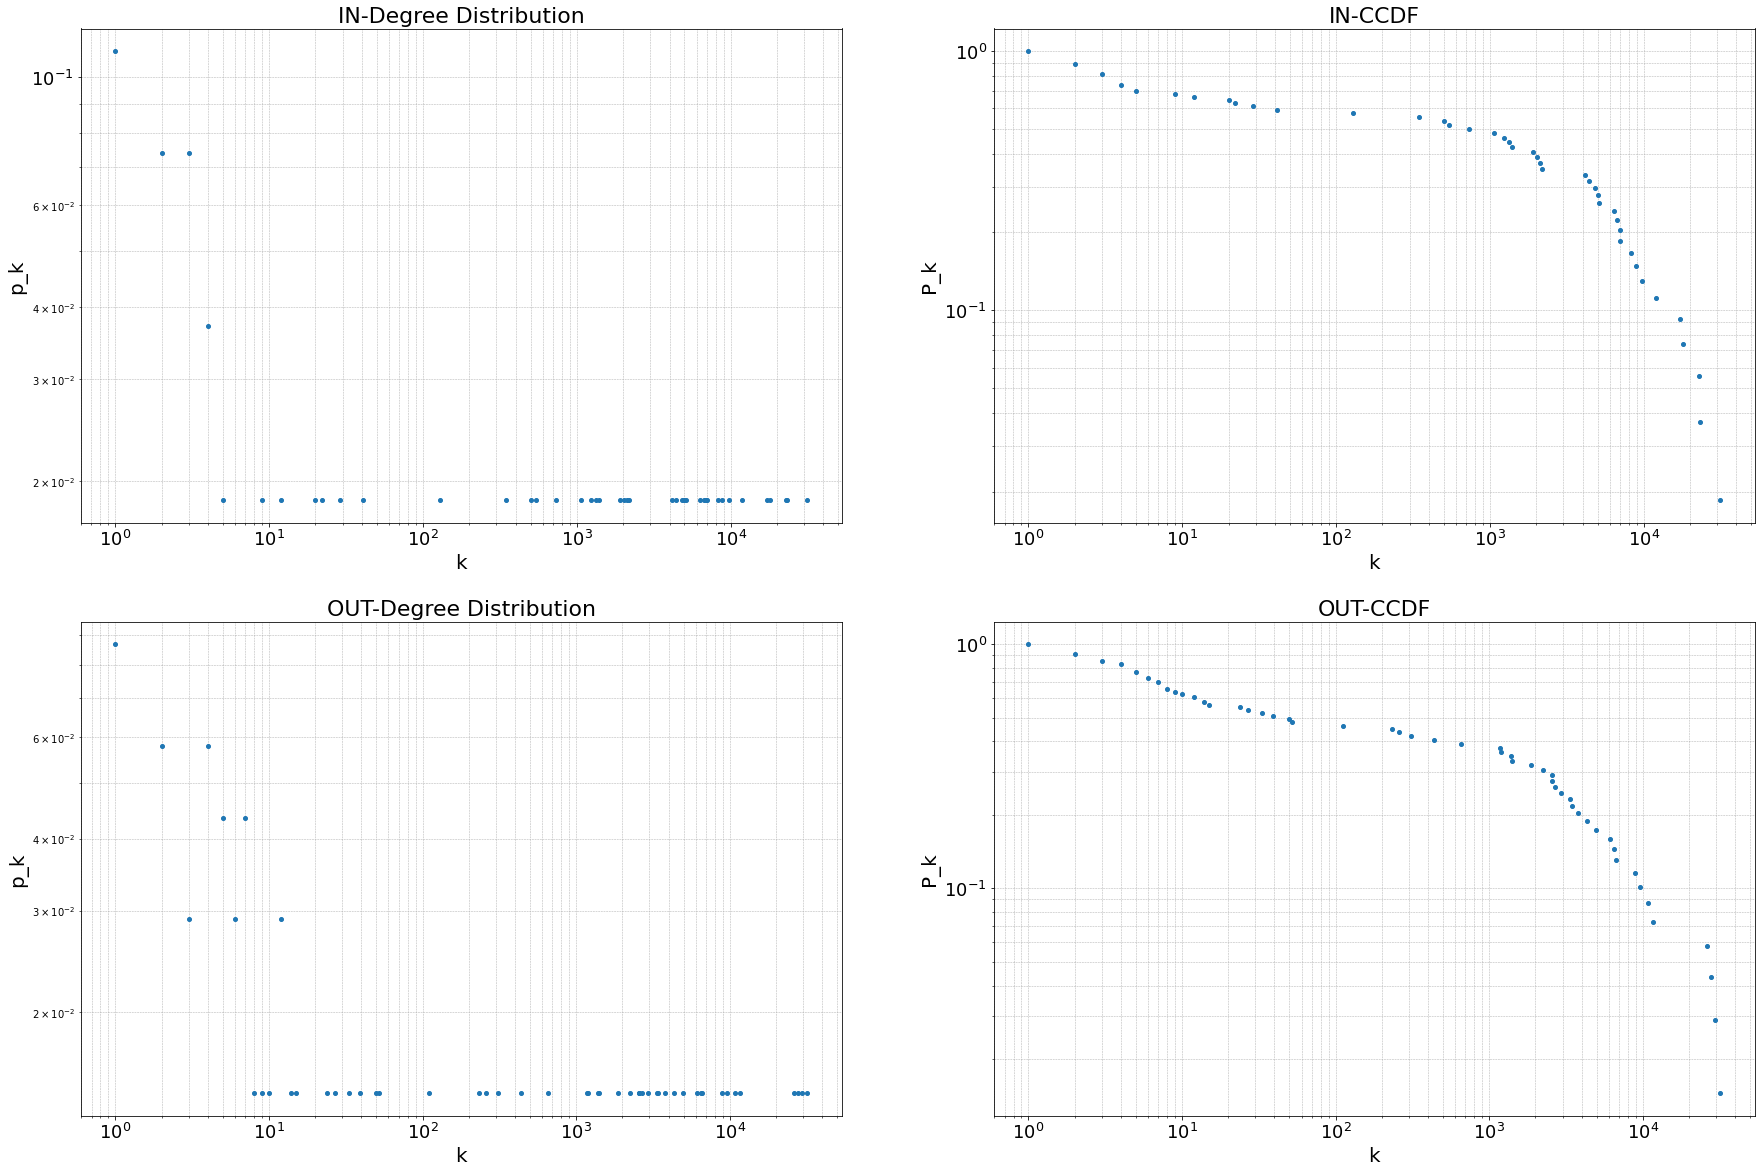

Top 10 for in degree


Nodes  in degree
46        Spain      31328
39      Germany      23334
50       France      22774
66           UK      17896
15        Italy      17313
1        Poland      11915
48     Portugal       9770
53  Netherlands       8832
55       Sweden       8277
14      Finland       6992

Top 10 for out degree


Nodes  out degree
39      Germany       31842
46        Spain       29491
50       France       27790
15        Italy       26119
60       Turkey       11601
1        Poland       10874
66           UK        9630
53  Netherlands        8838
37      Belgium        6641
61      Czechia        6492

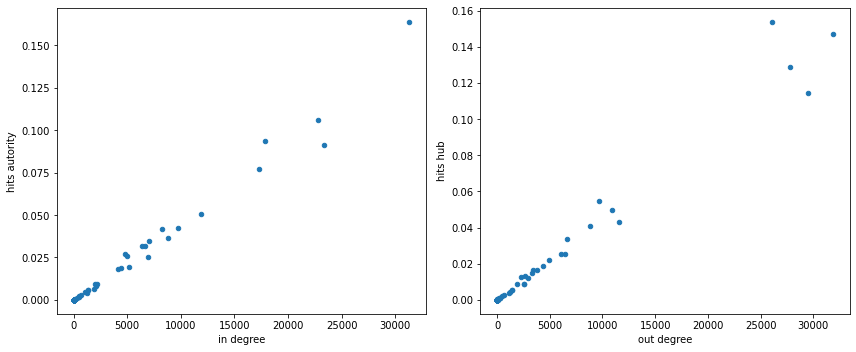

Top 10 for hits hub


Nodes  hits hub
15        Italy  0.153959
39      Germany  0.147386
50       France  0.128948
46        Spain  0.114324
66           UK  0.054692
1        Poland  0.049684
60       Turkey  0.042843
53  Netherlands  0.040712
37      Belgium  0.033620
48     Portugal  0.025642

Top 10 for hits autority


Nodes  hits autority
46        Spain       0.164030
50       France       0.106196
66           UK       0.093642
39      Germany       0.091452
15        Italy       0.076907
1        Poland       0.050483
48     Portugal       0.042417
55       Sweden       0.041725
53  Netherlands       0.036388
14      Finland       0.034568

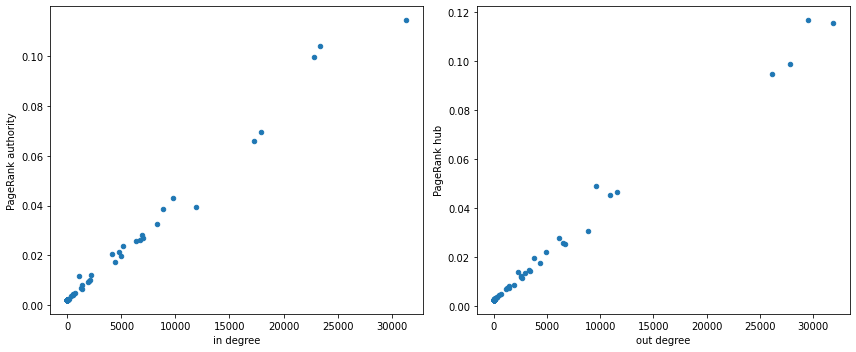

Top 10 for PageRank hub


Nodes  PageRank hub
46        Spain      0.116762
39      Germany      0.115689
50       France      0.098750
15        Italy      0.094661
66           UK      0.048974
60       Turkey      0.046628
1        Poland      0.045302
53  Netherlands      0.030773
48     Portugal      0.028010
61      Czechia      0.026003

Top 10 for PageRank authority


Nodes  PageRank authority
46        Spain            0.114362
39      Germany            0.104124
50       France            0.099493
66           UK            0.069481
15        Italy            0.066042
48     Portugal            0.042854
1        Poland            0.039454
53  Netherlands            0.038527
55       Sweden            0.032644
61      Czechia            0.028223

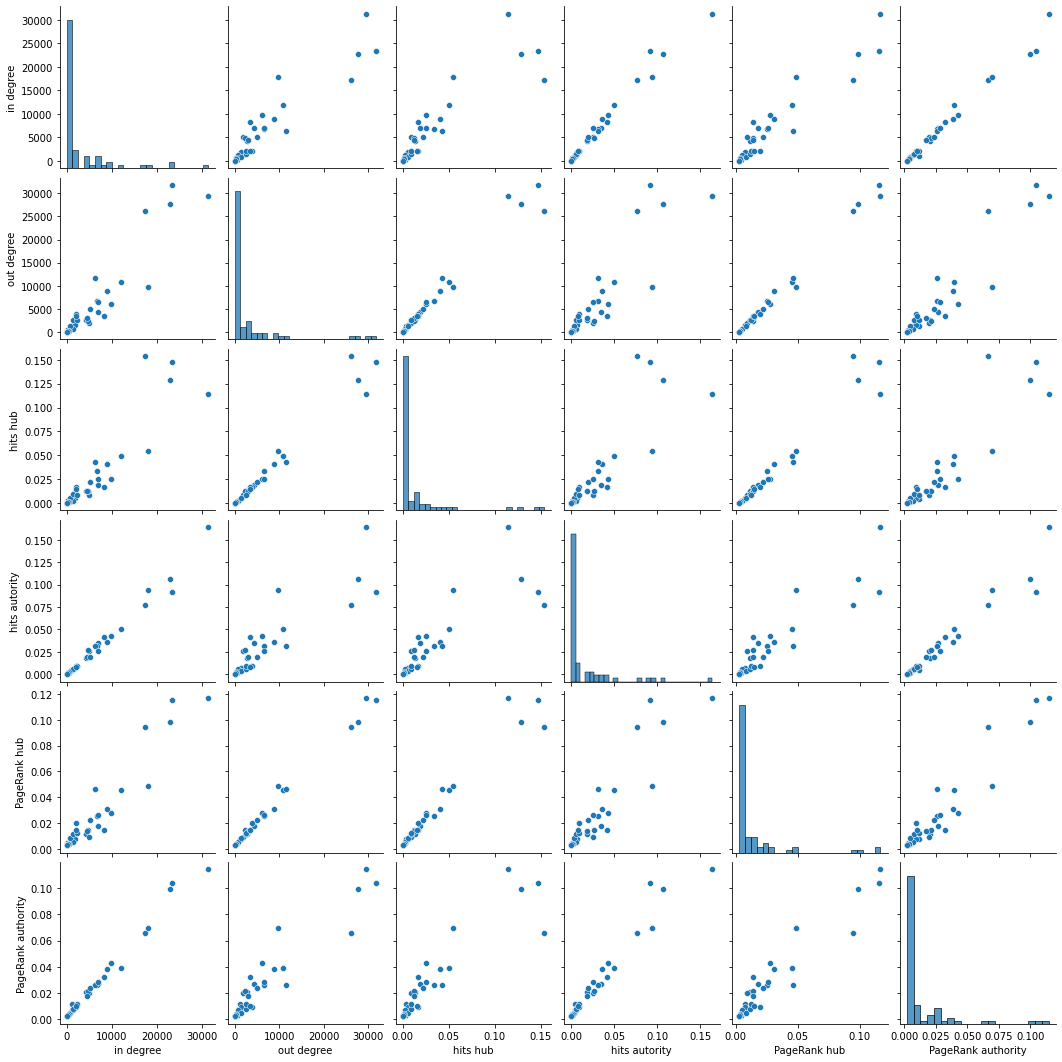

Nodes  in degree  in degree position  hits autority  \
46               Spain      31328                   1       0.164030   
39             Germany      23334                   2       0.091452   
50              France      22774                   3       0.106196   
66                  UK      17896                   4       0.093642   
15               Italy      17313                   5       0.076907   
48            Portugal       9770                   7       0.042417   
1               Poland      11915                   6       0.050483   
53         Netherlands       8832                   8       0.036388   
55              Sweden       8277                   9       0.041725   
61             Czechia       6950                  11       0.025480   
14             Finland       6992                  10       0.034568   
37             Belgium       6689                  12       0.031768   
60              Turkey       6356                  13       0.031474   
57             Austria       5143                  14       0.019585   
33             Ireland       4808                  16       0.026830   
0              Denmark       4153                  18       0.018201   
21              Norway       5003                  15       0.025615   
45             Hungary       4419                  17       0.019052   
54           Lithuania       2185                  19       0.009079   
6               Latvia       1065                  26       0.004839   
63                  EL       2115                  20       0.008328   
29             Romania       2014                  21       0.009355   
10            Slovenia       1910                  22       0.006646   
32            Slovakia       1387                  23       0.005585   
4              Croatia       1242                  25       0.004221   
28             Estonia       1326                  24       0.006006   
31            Bulgaria        735                  27       0.003097   
23              Cyprus        539                  28       0.001746   
65             Iceland        505                  29       0.002442   
70               Malta        347                  30       0.001382   
26          Luxembourg        129                  31       0.000776   
52       Liechtenstein         41                  32       0.000120   
58  Russian Federation         29                  33       0.000149   
9        United States         22                  34       0.000115   
24     North Macedonia         20                  35       0.000052   
17  Korea, Republic of         12                  36       0.000044   
27              Canada          9                  37       0.000041   
20              Brazil          5                  38       0.000007   
62           Hong Kong          3                  42       0.000007   
47            Thailand          3                  44       0.000009   

    hits autority position  PageRank authority  PageRank authority position  
46                       1            0.114362                            1  
39                       4            0.104124                            2  
50                       2            0.099493                            3  
66                       3            0.069481                            4  
15                       5            0.066042                            5  
48                       7            0.042854                            6  
1                        6            0.039454                            7  
53                       9            0.038527                            8  
55                       8            0.032644                            9  
61                      15            0.028223                           10  
14                      10            0.026799                           11  
37                      11            0.026297                           12  
60                      12            0.025807    

Nodes  out degree  out degree position  hits hub  \
46               Spain       29491                    2  0.114324   
39             Germany       31842                    1  0.147386   
50              France       27790                    3  0.128948   
15               Italy       26119                    4  0.153959   
66                  UK        9630                    7  0.054692   
60              Turkey       11601                    5  0.042843   
1               Poland       10874                    6  0.049684   
53         Netherlands        8838                    8  0.040712   
48            Portugal        6081                   11  0.025642   
61             Czechia        6492                   10  0.025322   
37             Belgium        6641                    9  0.033620   
57             Austria        4940                   12  0.022294   
29             Romania        3770                   14  0.016433   
14             Finland        4329                   13  0.018747   
63                  EL        3337                   16  0.015089   
55              Sweden        3436                   15  0.016781   
33             Ireland        2255                   21  0.012472   
45             Hungary        2944                   17  0.012341   
54           Lithuania        2550                   20  0.008745   
32            Slovakia        2568                   19  0.009045   
0              Denmark        2683                   18  0.013080   
21              Norway        1869                   22  0.008825   
31            Bulgaria        1378                   24  0.005649   
10            Slovenia        1407                   23  0.005383   
4              Croatia        1191                   25  0.004348   
6               Latvia        1173                   26  0.003807   
28             Estonia         653                   27  0.002497   
26          Luxembourg         439                   28  0.002321   
23              Cyprus         310                   29  0.001054   
65             Iceland         260                   30  0.000968   
70               Malta         232                   31  0.000957   
24     North Macedonia         111                   32  0.000276   
30             Ukraine          52                   33  0.000180   
58  Russian Federation          50                   34  0.000287   
34             Morocco          39                   35  0.000230   
19               China          33                   36  0.000170   
5               Serbia          24                   38  0.000109   
52       Liechtenstein          27                   37  0.000098   
44             Algeria          14                   40  0.000031   
27              Canada          12                   42  0.000070   

    hits hub position  PageRank hub  PageRank hub position  
46                  4      0.116762                      1  
39                  2      0.115689                      2  
50                  3      0.098750                      3  
15                  1      0.094661                      4  
66                  5      0.048974                      5  
60                  7      0.046628                      6  
1                   6      0.045302                      7  
53                  8      0.030773                      8  
48                 10      0.028010                      9  
61                 11      0.026003                     10  
37                  9      0.025457                     11  
57                 12      0.022232                     12  
29                 15      0.019659                     13  
14                 13      0.017803                     14  
63                 16      0.014721                     15  
55                 14      0.014326                     16  
33                 18      0.014202                     17  
45                 19      0.013761                     18  
54                 22      0

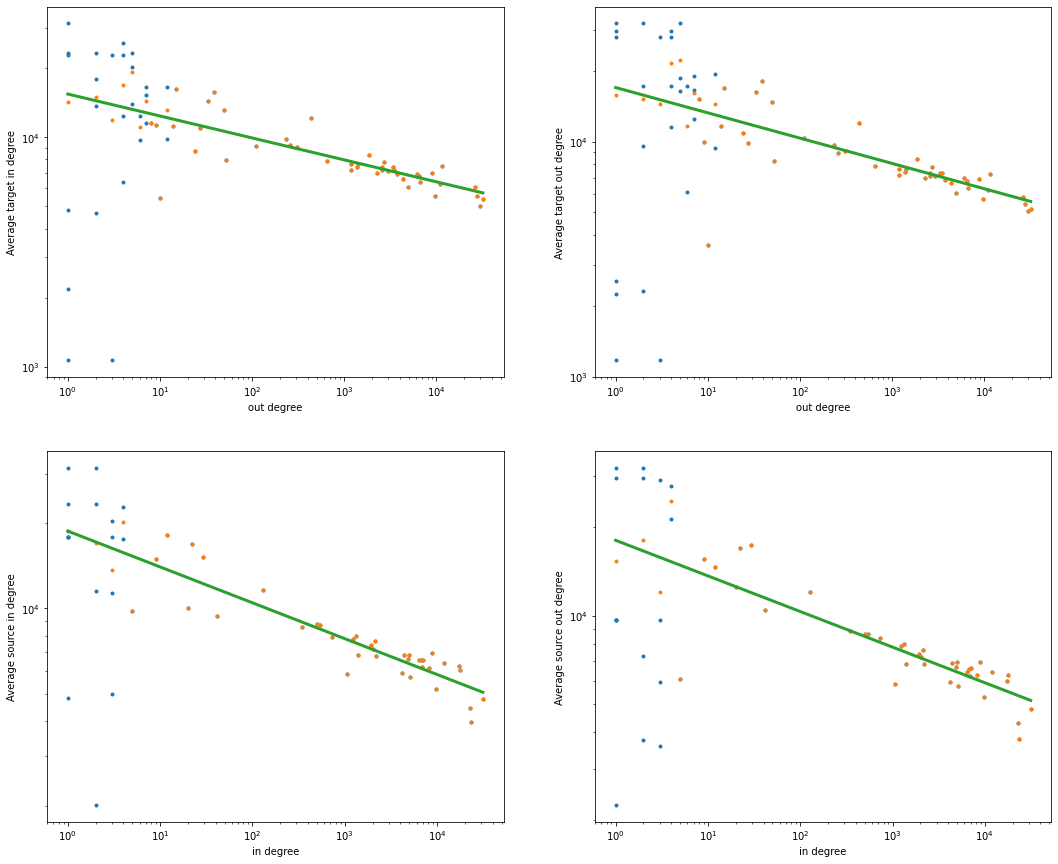

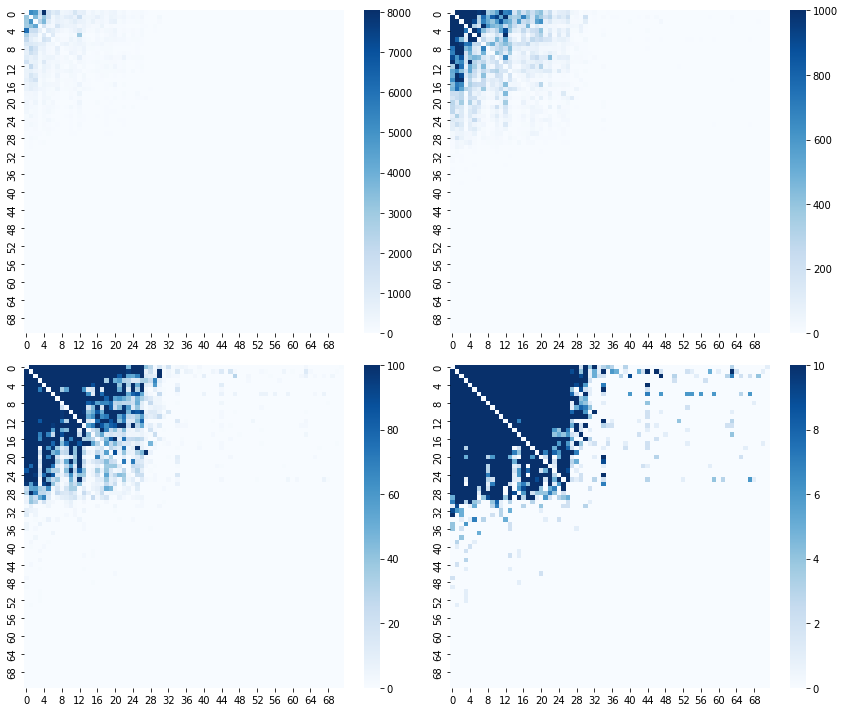

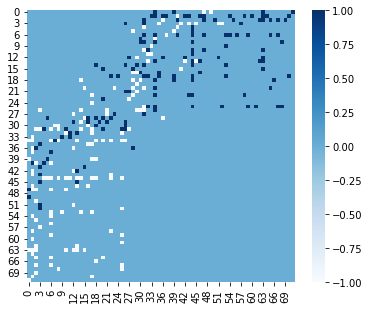

In [17]:
country15_df = pd.read_csv('data\Erasmus15.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country15_df)

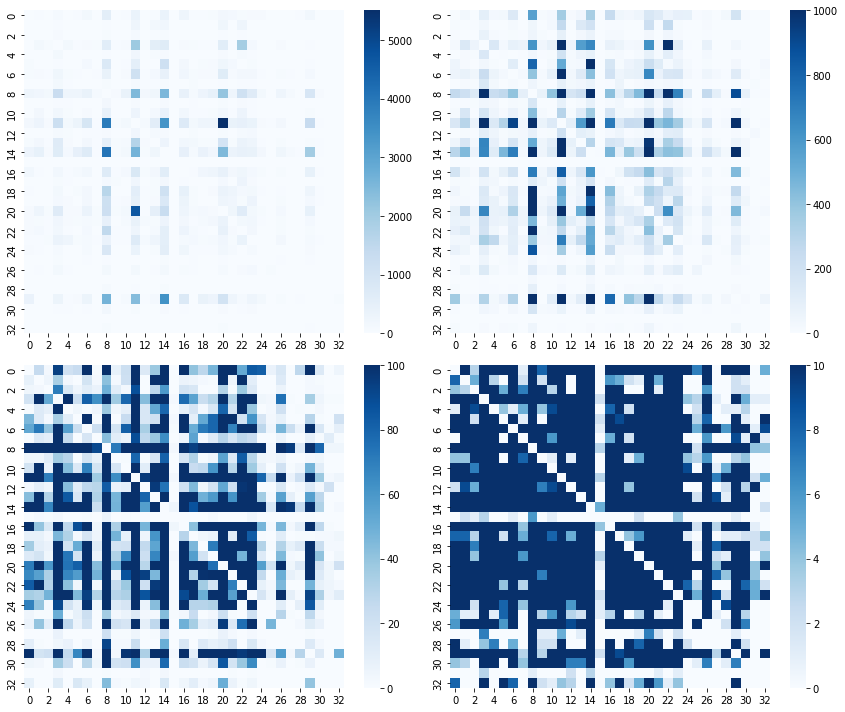

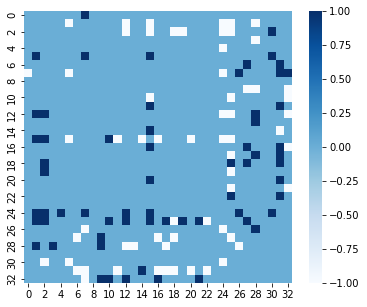

Number of components = 1


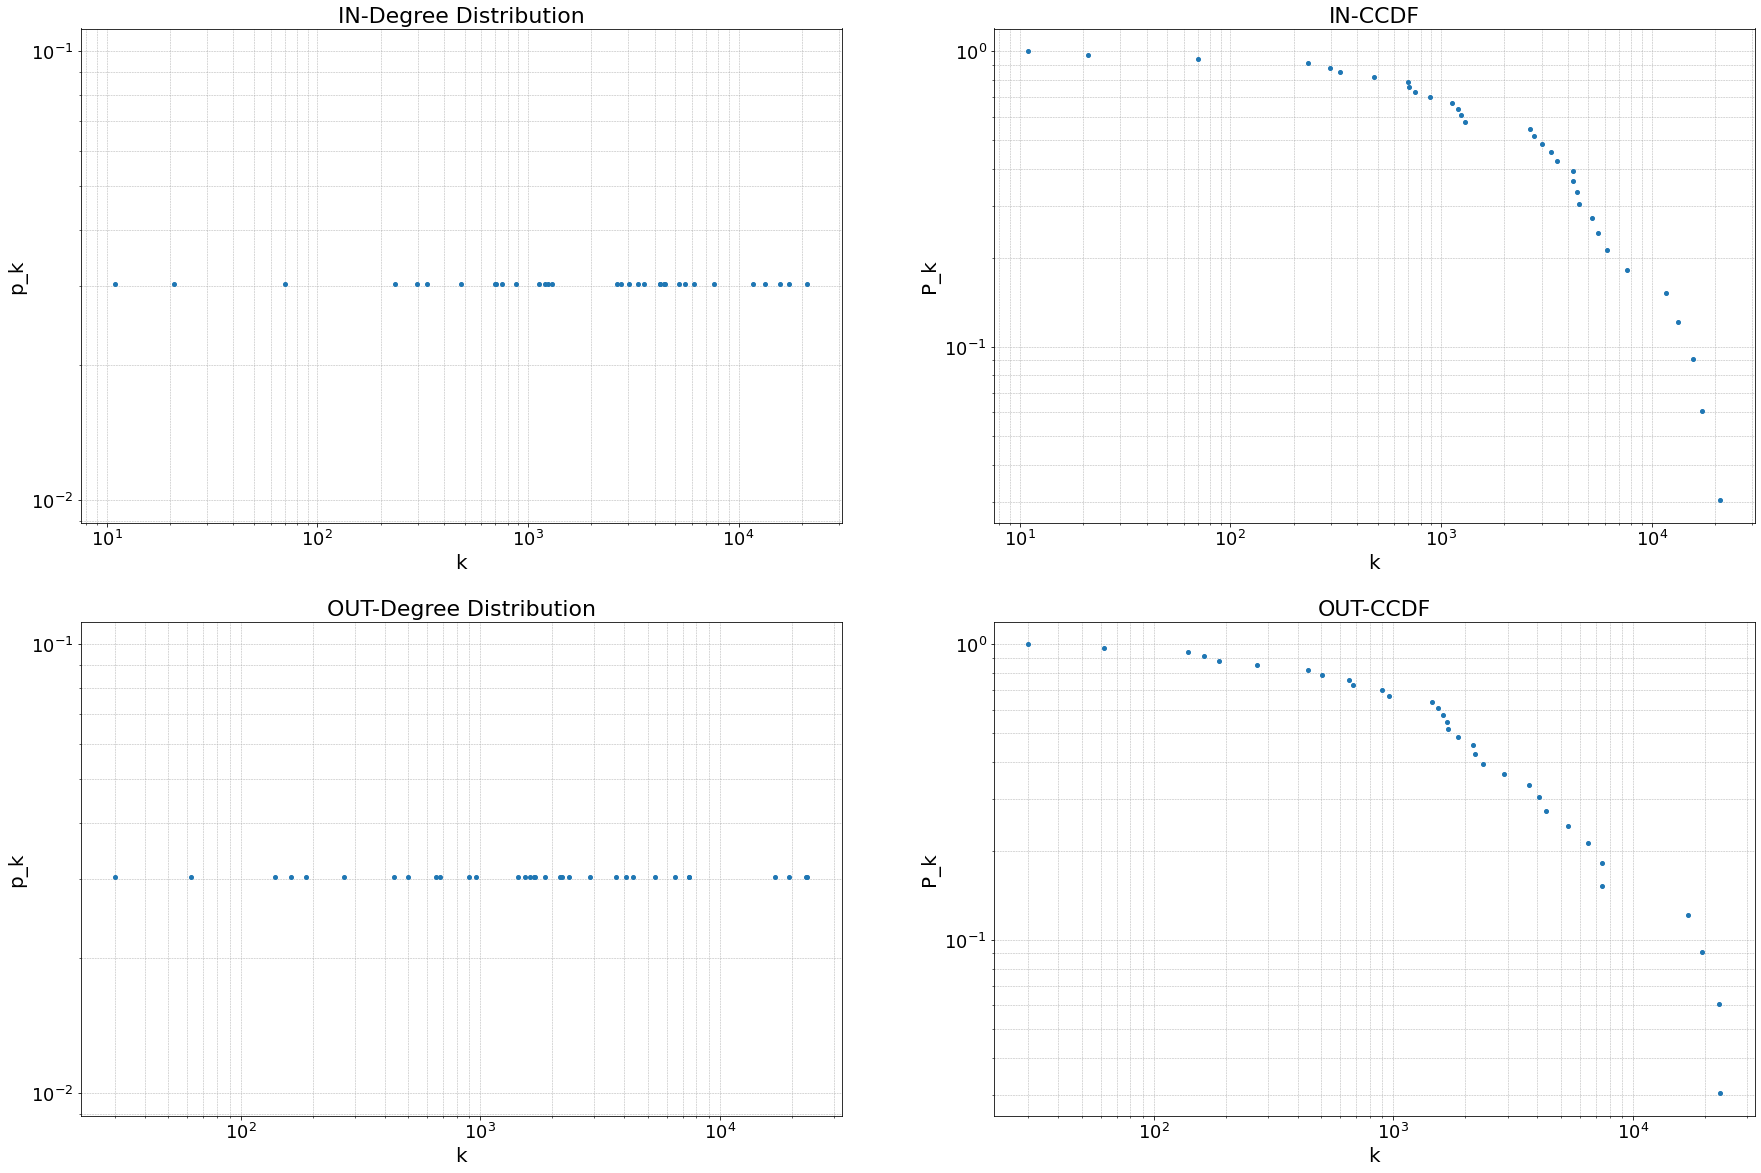

Top 10 for in degree


Nodes  in degree
11        Spain      21119
14       France      17250
8       Germany      15714
29           UK      13281
20        Italy      11699
3        Poland       7628
13     Portugal       6146
18       Sweden       5562
16  Netherlands       5232
19      Finland       4494

Top 10 for out degree


Nodes  out degree
11        Spain       23155
8       Germany       22824
14       France       19399
20        Italy       17047
3        Poland        7462
22       Turkey        7441
29           UK        6492
16  Netherlands        5390
6       Belgium        4330
23      Czechia        4066

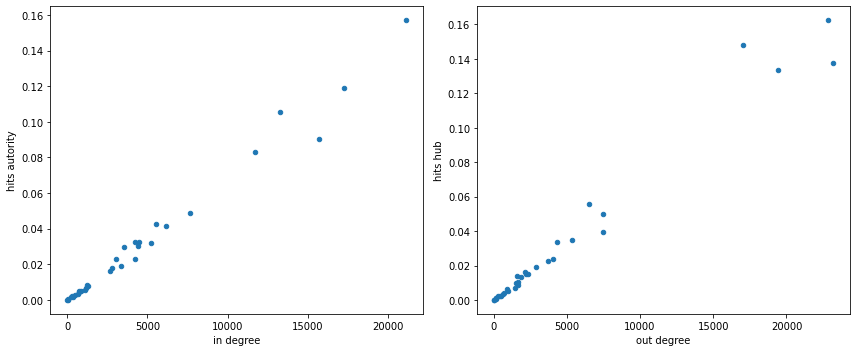

Top 10 for hits hub


Nodes  hits hub
8       Germany  0.162275
20        Italy  0.147887
11        Spain  0.137271
14       France  0.133438
29           UK  0.055983
3        Poland  0.050064
22       Turkey  0.039574
16  Netherlands  0.035035
6       Belgium  0.033543
23      Czechia  0.023626

Top 10 for hits autority


Nodes  hits autority
11     Spain       0.156956
14    France       0.118921
29        UK       0.105617
8    Germany       0.090148
20     Italy       0.082788
3     Poland       0.048618
18    Sweden       0.042787
13  Portugal       0.041566
19   Finland       0.032696
22    Turkey       0.032405

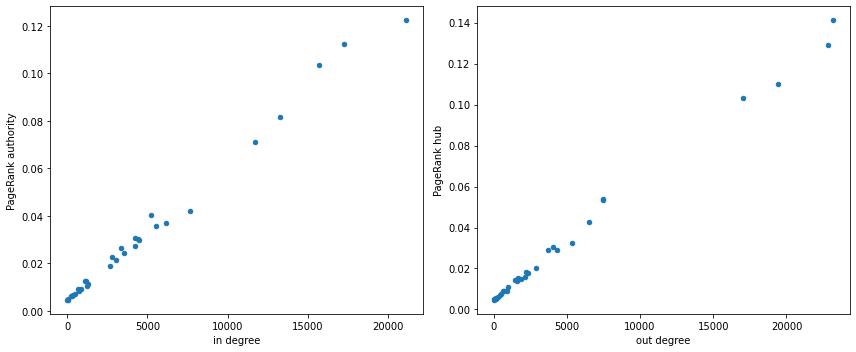

Top 10 for PageRank hub


Nodes  PageRank hub
11        Spain      0.141112
8       Germany      0.129106
14       France      0.110293
20        Italy      0.103348
3        Poland      0.054073
22       Turkey      0.053611
29           UK      0.042490
16  Netherlands      0.032353
23      Czechia      0.030299
13     Portugal      0.029030

Top 10 for PageRank authority


Nodes  PageRank authority
11        Spain            0.122351
14       France            0.112269
8       Germany            0.103498
29           UK            0.081532
20        Italy            0.070998
3        Poland            0.041874
16  Netherlands            0.040290
13     Portugal            0.036863
18       Sweden            0.035680
23      Czechia            0.030777

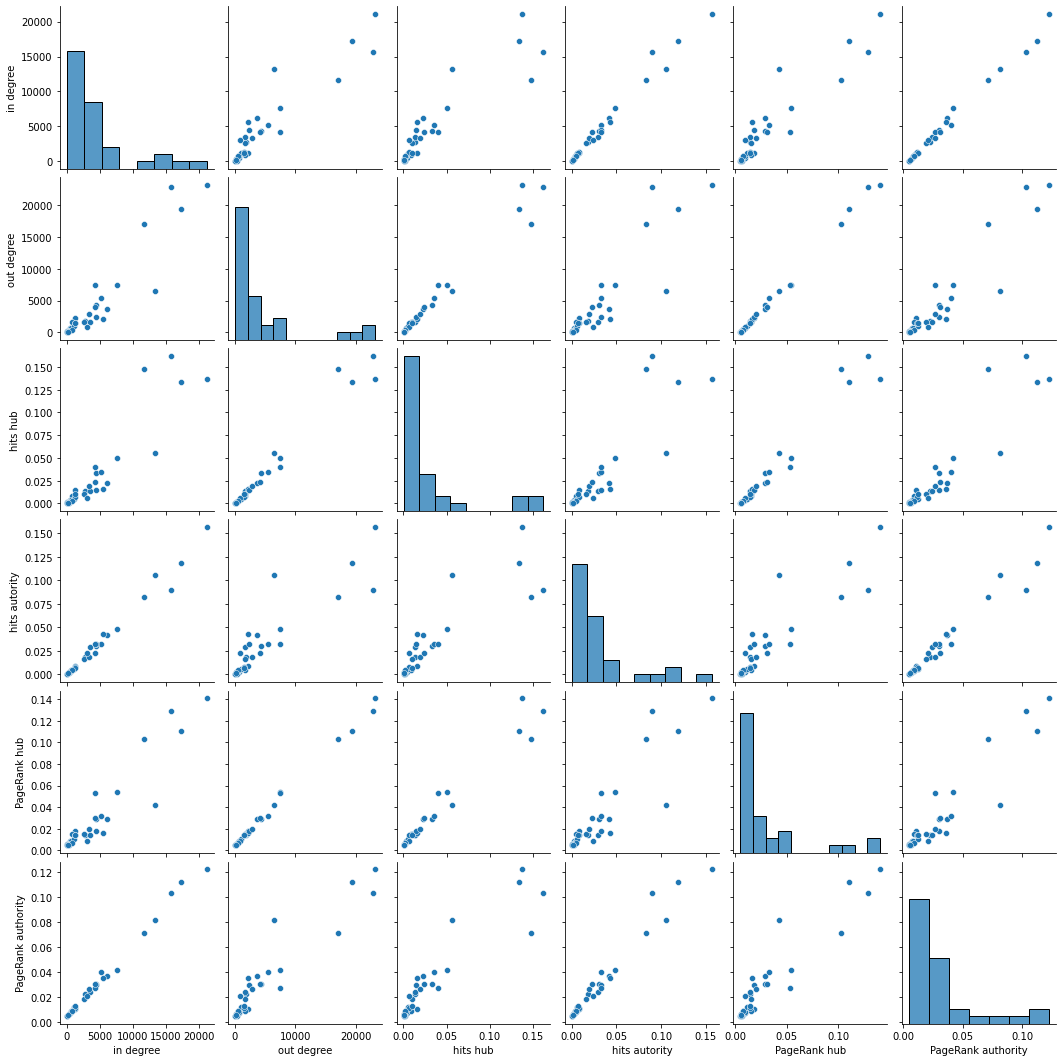

Nodes  in degree  in degree position  hits autority  \
11            Spain      21119                   1       0.156956   
14           France      17250                   2       0.118921   
8           Germany      15714                   3       0.090148   
29               UK      13281                   4       0.105617   
20            Italy      11699                   5       0.082788   
3            Poland       7628                   6       0.048618   
16      Netherlands       5232                   9       0.032177   
13         Portugal       6146                   7       0.041566   
18           Sweden       5562                   8       0.042787   
23          Czechia       4234                  13       0.023135   
6           Belgium       4413                  11       0.030519   
19          Finland       4494                  10       0.032696   
22           Turkey       4251                  12       0.032405   
21          Austria       3342                  15       0.019049   
5           Ireland       3545                  14       0.029458   
0           Denmark       2764                  17       0.018001   
24           Norway       3021                  16       0.023204   
10          Hungary       2648                  18       0.016353   
26               EL       1201                  21       0.006676   
12         Slovenia       1130                  22       0.005621   
17        Lithuania       1306                  19       0.007822   
1           Romania       1247                  20       0.008469   
4          Slovakia        882                  23       0.005118   
7           Croatia        697                  26       0.003269   
30          Estonia        756                  24       0.004975   
9            Latvia        704                  25       0.004647   
2          Bulgaria        483                  27       0.002911   
25           Cyprus        332                  28       0.001673   
28          Iceland        297                  29       0.002126   
32            Malta        234                  30       0.001527   
27       Luxembourg         70                  31       0.000613   
15    Liechtenstein         21                  32       0.000100   
31  North Macedonia         11                  33       0.000055   

    hits autority position  PageRank authority  PageRank authority position  
11                       1            0.122351                            1  
14                       2            0.112269                            2  
8                        4            0.103498                            3  
29                       3            0.081532                            4  
20                       5            0.070998                            5  
3                        6            0.041874                            6  
16                      11            0.040290                            7  
13                       8            0.036863                            8  
18                       7            0.035680                            9  
23                      15            0.030777                           10  
6                       12            0.030385                           11  
19                       9            0.029802                           12  
22                      10            0.027118                           13  
21                      16            0.026471                           14  
5                       13            0.024297                           15  
0                       17            0.022712                           16  
24                      14            0.021254                           17  
10                      18            0.018899                           18  
26                      21            0.012545                           19  
12                      22            0.012368                           20  
17                      20   

Nodes  out degree  out degree position  hits hub  \
11            Spain       23155                    1  0.137271   
8           Germany       22824                    2  0.162275   
14           France       19399                    3  0.133438   
20            Italy       17047                    4  0.147887   
3            Poland        7462                    5  0.050064   
22           Turkey        7441                    6  0.039574   
29               UK        6492                    7  0.055983   
16      Netherlands        5390                    8  0.035035   
23          Czechia        4066                   10  0.023626   
13         Portugal        3694                   11  0.022424   
6           Belgium        4330                    9  0.033543   
21          Austria        2887                   12  0.019040   
1           Romania        2196                   14  0.015245   
19          Finland        2360                   13  0.015171   
18           Sweden        2159                   15  0.016356   
4          Slovakia        1681                   18  0.008573   
10          Hungary        1692                   17  0.010578   
0           Denmark        1860                   16  0.013242   
17        Lithuania        1445                   21  0.006855   
26               EL        1539                   20  0.009965   
5           Ireland        1611                   19  0.013796   
12         Slovenia         958                   22  0.005292   
24           Norway         899                   23  0.006516   
2          Bulgaria         682                   24  0.004288   
9            Latvia         652                   25  0.003334   
7           Croatia         502                   26  0.002617   
30          Estonia         439                   27  0.002435   
27       Luxembourg         271                   28  0.002151   
25           Cyprus         162                   30  0.000952   
28          Iceland         188                   29  0.001245   
32            Malta         139                   31  0.000883   
31  North Macedonia          62                   32  0.000155   
15    Liechtenstein          30                   33  0.000191   

    hits hub position  PageRank hub  PageRank hub position  
11                  3      0.141112                      1  
8                   1      0.129106                      2  
14                  4      0.110293                      3  
20                  2      0.103348                      4  
3                   6      0.054073                      5  
22                  7      0.053611                      6  
29                  5      0.042490                      7  
16                  8      0.032353                      8  
23                 10      0.030299                      9  
13                 11      0.029030                     10  
6                   9      0.028949                     11  
21                 12      0.020286                     12  
1                  14      0.018381                     13  
19                 15      0.018006                     14  
18                 13      0.016049                     15  
4                  20      0.015143                     16  
10                 18      0.015005                     17  
0                  17      0.014631                     18  
17                 21      0.014240                     19  
26                 19      0.014236                     20  
5                  16      0.013981                     21  
12                 23      0.011038                     22  
24                 22      0.009230                     23  
2                  24      0.009153                     24  
9                  25      0.008935                     25  
7                  26      0.007738                     26  
30                 27      0.007054                     27  
27                 28      0.006142                     28  


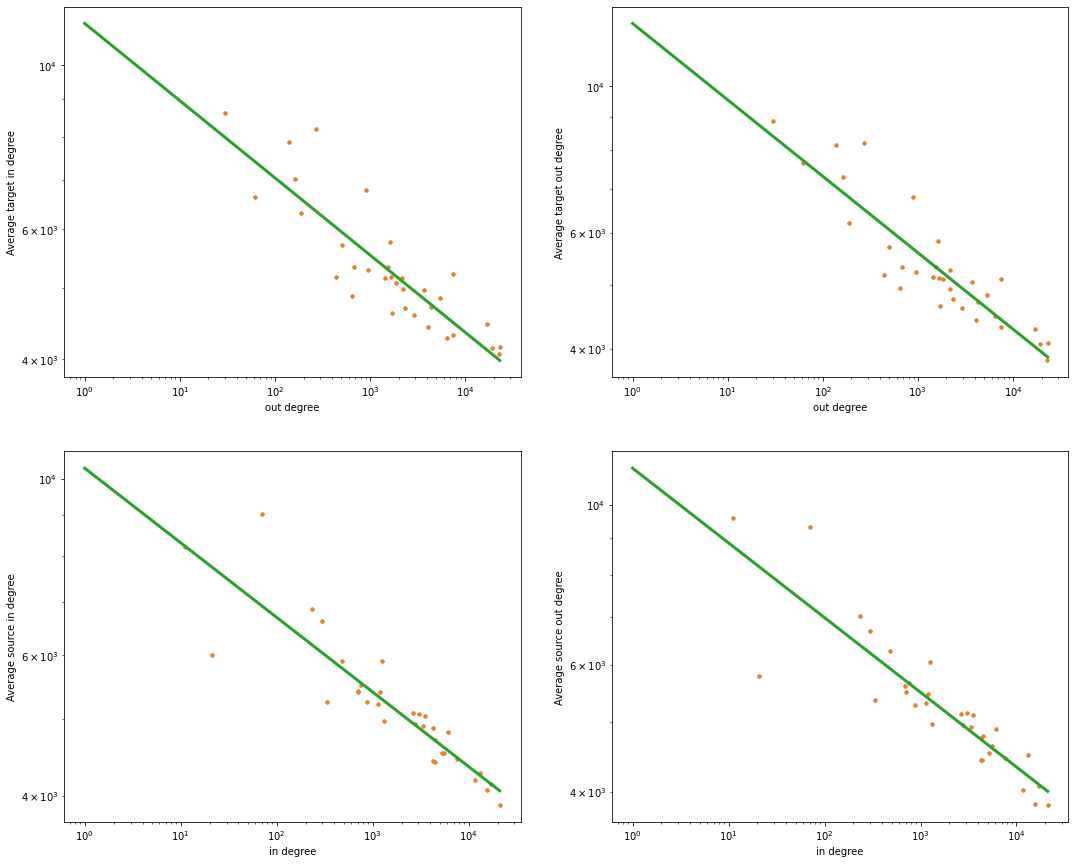

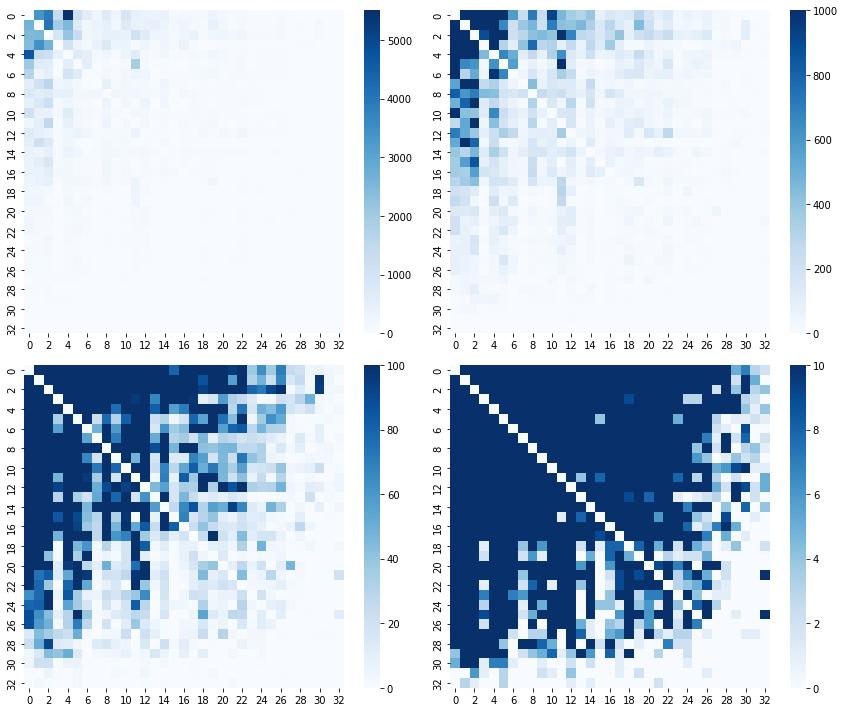

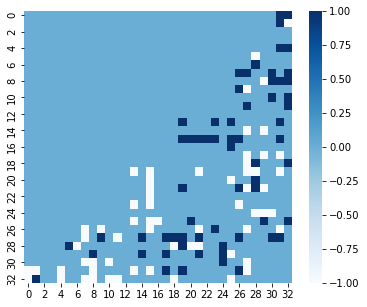

In [18]:
country14_df = pd.read_csv('data\Erasmus14.csv', sep=';',low_memory=False, header=0, encoding='utf8')
analysis(country14_df)

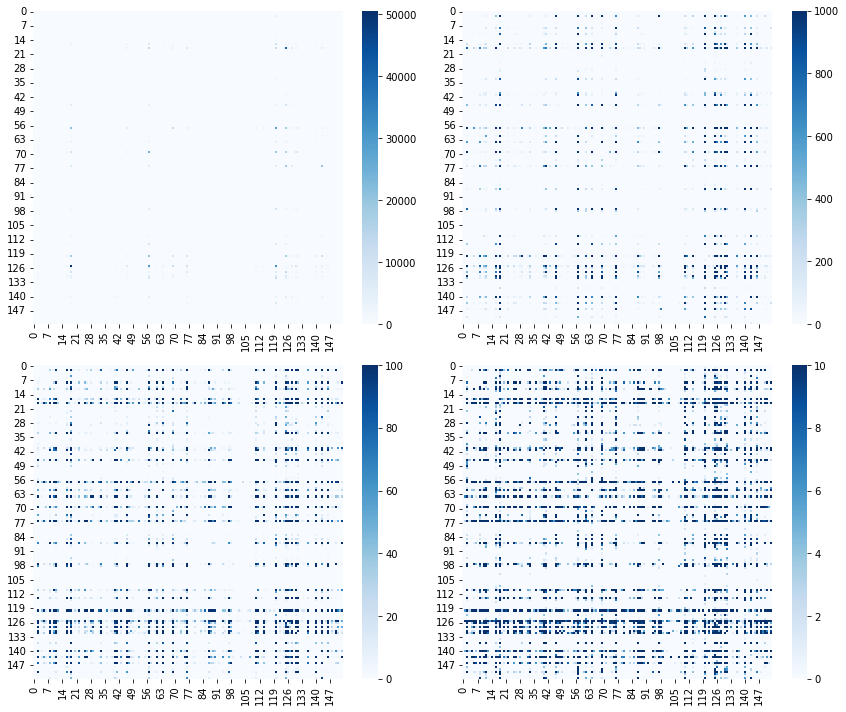

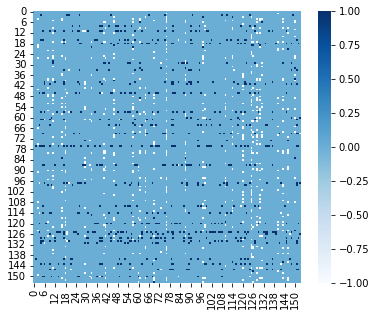

Number of components = 2


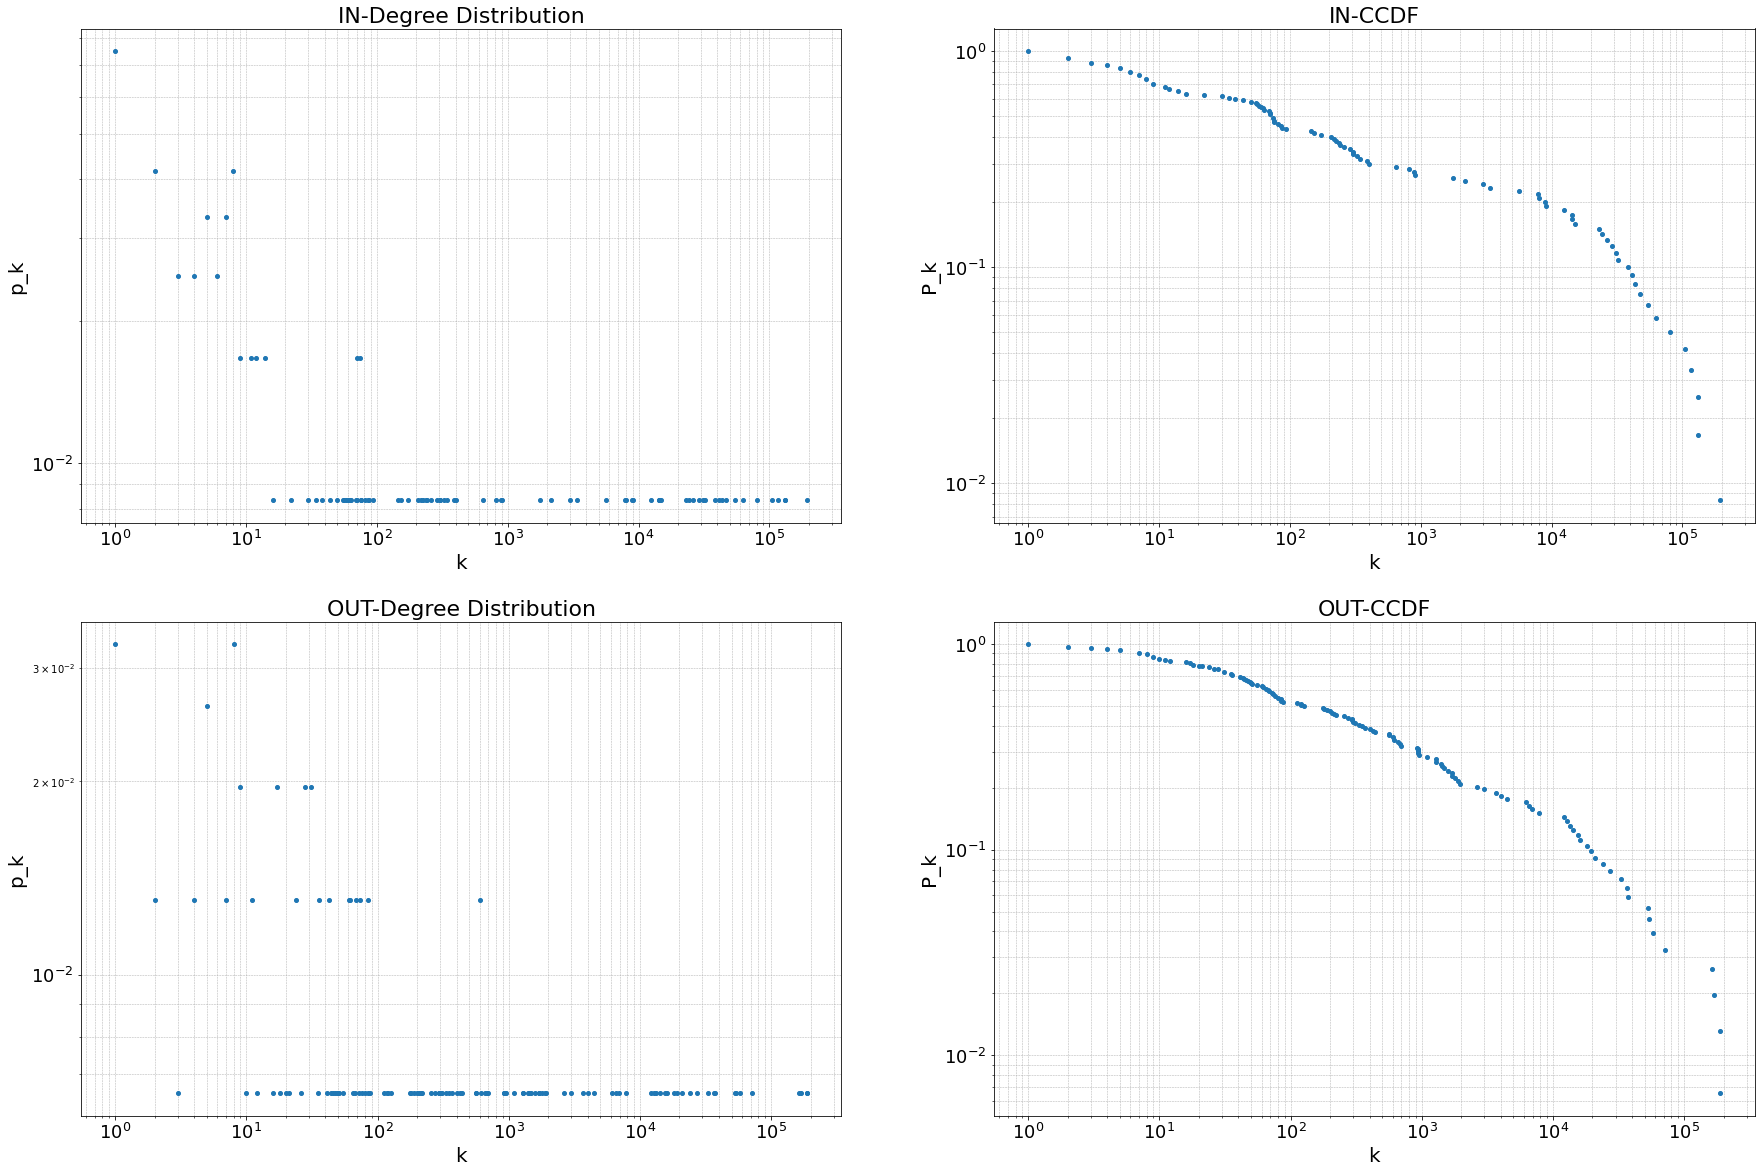

Top 10 for in degree


Nodes  in degree
125        Spain     193628
120      Germany     131451
57        France     130821
18         Italy     116180
69            UK     103962
76        Poland      79774
128     Portugal      63268
130  Netherlands      54828
131       Sweden      47028
140      Czechia      43532

Top 10 for out degree


Nodes  out degree
120      Germany      187627
125        Spain      186670
57        France      168162
18         Italy      162235
143       Turkey       71621
76        Poland       58299
69            UK       53862
130  Netherlands       53340
46       Belgium       37427
128     Portugal       36678

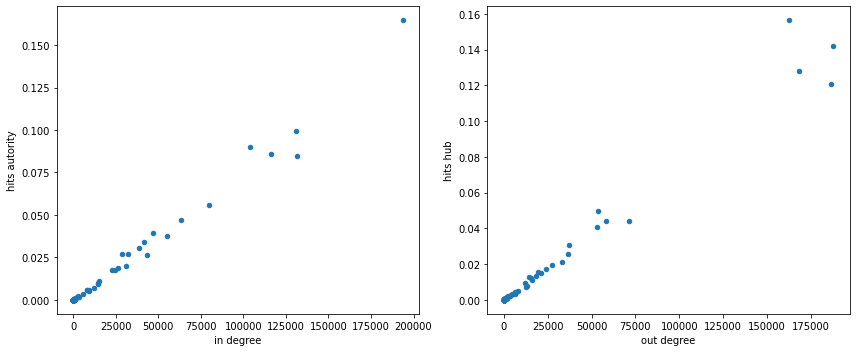

Top 10 for hits hub


Nodes  hits hub
18         Italy  0.156293
120      Germany  0.141831
57        France  0.128110
125        Spain  0.120733
69            UK  0.049901
76        Poland  0.044319
143       Turkey  0.043977
130  Netherlands  0.040685
46       Belgium  0.030840
128     Portugal  0.025639

Top 10 for hits autority


Nodes  hits autority
125        Spain       0.164556
57        France       0.099586
69            UK       0.089991
18         Italy       0.085836
120      Germany       0.084588
76        Poland       0.056051
128     Portugal       0.046731
131       Sweden       0.039643
130  Netherlands       0.037504
16       Finland       0.033788

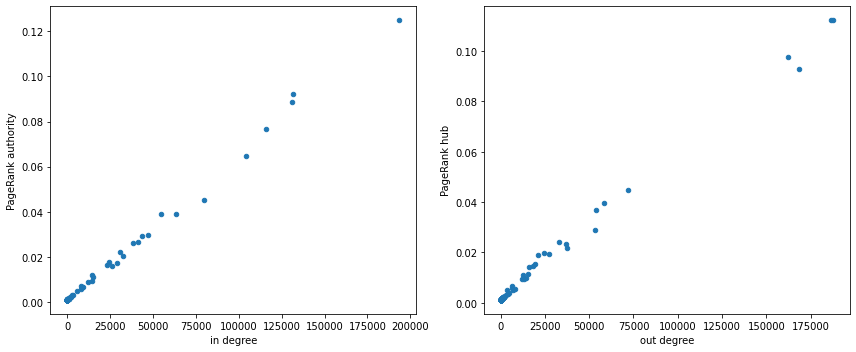

Top 10 for PageRank hub


Nodes  PageRank hub
120      Germany      0.112138
125        Spain      0.112125
18         Italy      0.097475
57        France      0.092776
143       Turkey      0.044988
76        Poland      0.039472
69            UK      0.036884
130  Netherlands      0.028761
140      Czechia      0.024009
128     Portugal      0.023171

Top 10 for PageRank authority


Nodes  PageRank authority
125        Spain            0.124839
120      Germany            0.092253
57        France            0.088529
18         Italy            0.076540
69            UK            0.064553
76        Poland            0.045153
128     Portugal            0.039174
130  Netherlands            0.038861
131       Sweden            0.029709
140      Czechia            0.029178

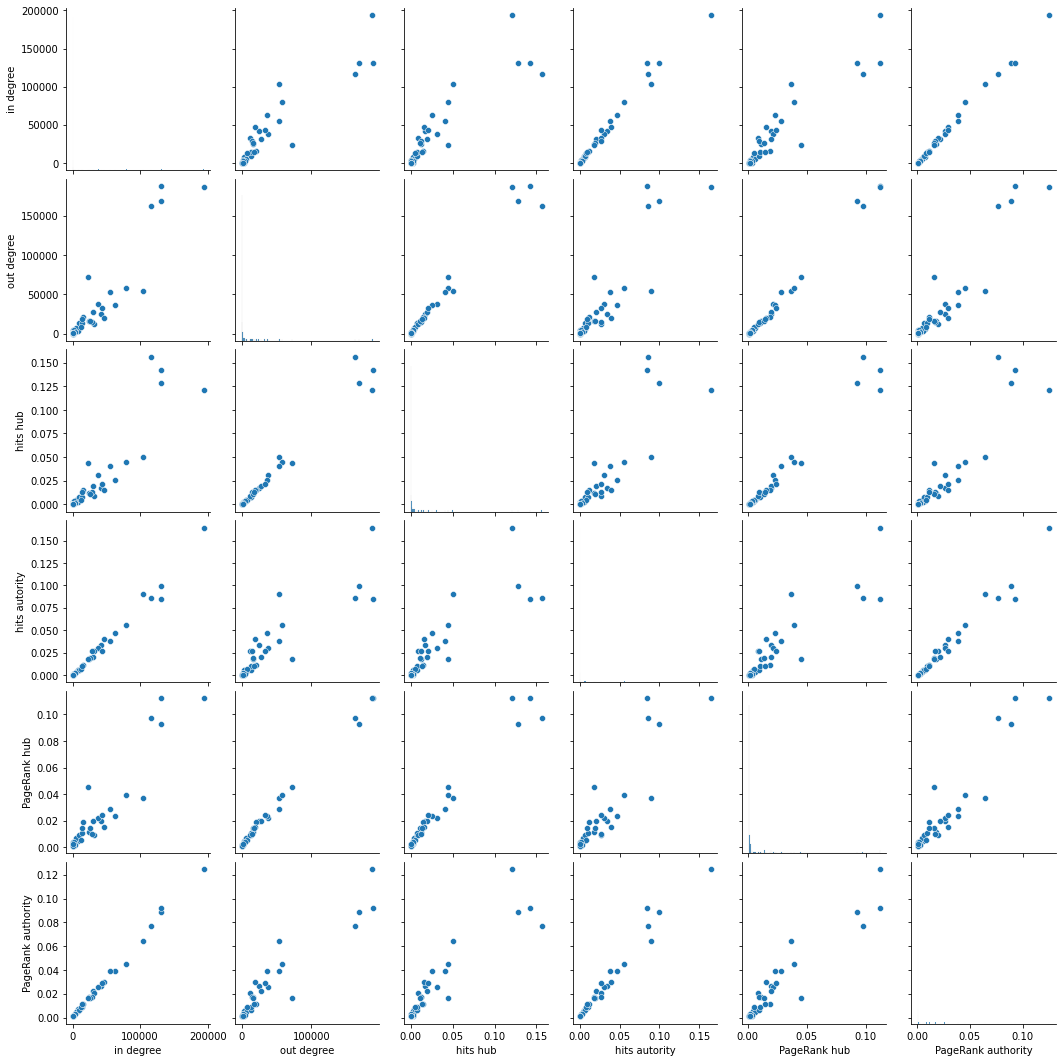

Nodes  in degree  in degree position  hits autority  \
125                   Spain     193628                   1       0.164556   
120                 Germany     131451                   2       0.084588   
57                   France     130821                   3       0.099586   
18                    Italy     116180                   4       0.085836   
69                       UK     103962                   5       0.089991   
76                   Poland      79774                   6       0.056051   
128                Portugal      63268                   7       0.046731   
130             Netherlands      54828                   8       0.037504   
131                  Sweden      47028                   9       0.039643   
140                 Czechia      43532                  10       0.026612   
16                  Finland      41491                  11       0.033788   
46                  Belgium      38404                  12       0.030425   
64                  Austria      30949                  14       0.020008   
97                   Norway      32344                  13       0.027140   
2                   Denmark      24228                  17       0.017316   
114                 Ireland      28897                  15       0.026713   
143                  Turkey      23039                  18       0.017419   
126                 Hungary      26280                  16       0.018527   
146                      EL      14333                  20       0.009585   
110                 Romania      14966                  19       0.011204   
61                Lithuania      14273                  21       0.009962   
87                 Slovenia      12383                  22       0.007141   
11                   Latvia       8064                  25       0.006076   
8                   Croatia       9059                  23       0.005239   
41                 Slovakia       8950                  24       0.005978   
33                  Estonia       7844                  26       0.005851   
40                 Bulgaria       5609                  27       0.003485   
98                   Cyprus       3364                  28       0.001827   
150                 Iceland       2995                  29       0.002287   
73                    Malta       2161                  30       0.001473   
136      Russian Federation       1758                  31       0.001265   
28                   Israel        892                  33       0.000605   
10                   Serbia        908                  32       0.000602   
29               Luxembourg        812                  34       0.000725   
85            United States        643                  35       0.000460   
32                   Canada        401                  36       0.000289   
22                    China        302                  41       0.000125   
153         North Macedonia        390                  37       0.000238   
25   Bosnia and Herzegovina        345                  38       0.000210   
74                    Japan        326                  39       0.000264   

     hits autority position  PageRank authority  PageRank authority position  
125                       1            0.124839                            1  
120                       5            0.092253                            2  
57                        2            0.088529                            3  
18                        4            0.076540                            4  
69                        3            0.064553                            5  
76                        6            0.045153                            6  
128                       7            0.039174                            7  
130                       9            0.038861                            8  
131                       8            0.029709                            9  
140                      14            0.029178                           

Nodes  out degree  out degree position  hits hub  \
120                 Germany      187627                    1  0.141831   
125                   Spain      186670                    2  0.120733   
18                    Italy      162235                    4  0.156293   
57                   France      168162                    3  0.128110   
143                  Turkey       71621                    5  0.043977   
76                   Poland       58299                    6  0.044319   
69                       UK       53862                    7  0.049901   
130             Netherlands       53340                    8  0.040685   
140                 Czechia       32912                   11  0.021089   
128                Portugal       36678                   10  0.025639   
46                  Belgium       37427                    9  0.030840   
16                  Finland       24264                   13  0.017102   
64                  Austria       27204                   12  0.019678   
110                 Romania       21012                   14  0.014906   
131                  Sweden       19337                   15  0.015423   
146                      EL       18254                   16  0.013360   
126                 Hungary       16068                   17  0.011245   
2                   Denmark       15651                   18  0.012205   
61                Lithuania       12867                   21  0.007240   
114                 Ireland       14255                   19  0.012791   
41                 Slovakia       13370                   20  0.007605   
97                   Norway       12075                   22  0.009214   
40                 Bulgaria        6558                   25  0.004334   
11                   Latvia        6178                   26  0.003345   
87                 Slovenia        7847                   23  0.004957   
8                   Croatia        6937                   24  0.004517   
33                  Estonia        3696                   29  0.002296   
136      Russian Federation        4500                   27  0.003247   
111                 Ukraine        4025                   28  0.002819   
10                   Serbia        2962                   30  0.002150   
29               Luxembourg        2653                   31  0.002165   
88                  Georgia        1893                   33  0.001299   
43                  Morocco        1939                   32  0.001774   
98                   Cyprus        1714                   35  0.000830   
22                    China        1796                   34  0.001301   
5                   Tunisia        1708                   36  0.001601   
25   Bosnia and Herzegovina        1584                   37  0.001099   
153         North Macedonia        1290                   41  0.000470   
127                 Albania        1438                   39  0.000992   
28                   Israel        1277                   42  0.000881   

     hits hub position  PageRank hub  PageRank hub position  
120                  2      0.112138                      1  
125                  4      0.112125                      2  
18                   1      0.097475                      3  
57                   3      0.092776                      4  
143                  7      0.044988                      5  
76                   6      0.039472                      6  
69                   5      0.036884                      7  
130                  8      0.028761                      8  
140                 11      0.024009                      9  
128                 10      0.023171                     10  
46                   9      0.021710                     11  
16                  13      0.019637                     12  
64                  12      0.019579                     13  
110                 15      0.019101                     14  
131                 14      0.015339                     

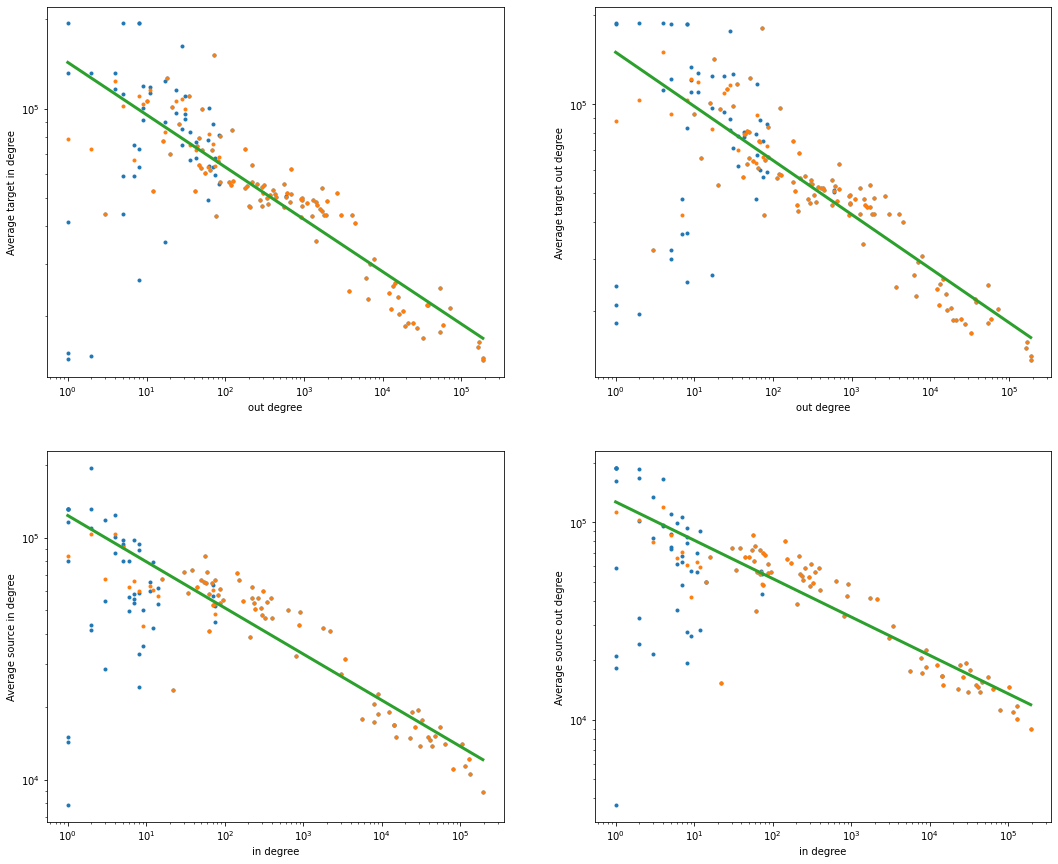

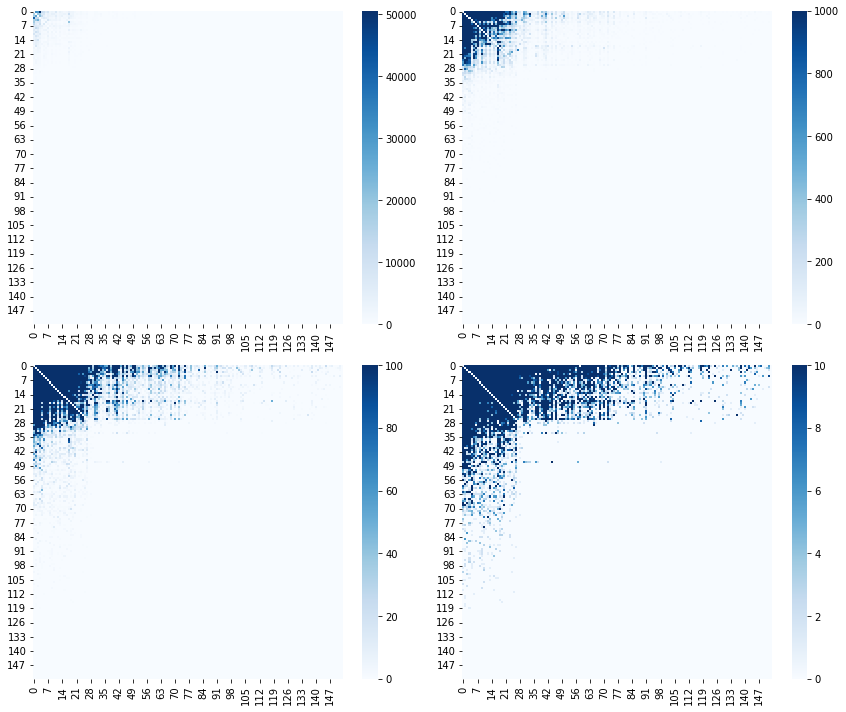

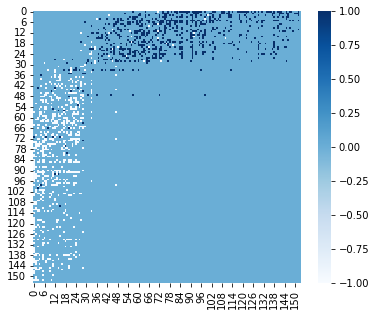

In [19]:
country_df = country19_df.append(country18_df)
country_df = country_df.append(country17_df)
country_df = country_df.append(country16_df)
country_df = country_df.append(country15_df)
country_df = country_df.append(country14_df)
analysis(country_df)

This is only a draft version of community detection

In [20]:
import networkx as nx
# import community

G = nx.convert_matrix.from_scipy_sparse_matrix(adj_matrix_crs)
p = nx.algorithms.community.modularity_max.greedy_modularity_communities(G)
node_comm = nodes_df.copy()

node_comm['Community']=np.zeros(len(node_comm.index),dtype='int8')
for i, set in enumerate(p):
    for element in set:
        node_comm.iat[element, 1]=i
for i, set in enumerate(p):
    display(node_comm[node_comm['Community']==i])


NameError: name 'adj_matrix_crs' is not defined

## Geographic Heat map 

In [ ]:
import geopandas as gpd

geo_df = gpd.read_file('countries.geojson')

def replace_iso2(alpha):
    try:
        return pc.countries.get(alpha_3=alpha).alpha_2
    except:
        return alpha
    
geo_df['iso2_code']= (np.array(list(map(lambda x: replace_iso2(x), geo_df['ISO_A3']))))

geo_df.columns = ['country', 'country_code', 'geometry', 'iso2_code']

In [ ]:
# adding code country to scores dataframe
countries_codes = nodes_df
countries_codes['code'] = nodes
scores_merge = pd.merge(left=countries_codes, right=scores, how='right', left_on='Nodes', right_on='Nodes')

# in geo_df United Kingdom has code GB, so we have to change it manually
geo_df.loc[geo_df['country'] == 'United Kingdom', 'iso2_code'] = 'UK'
geo_df.loc[geo_df['country'] == 'Greece', 'iso2_code'] = 'EL'
geo_df.loc[geo_df['country'] == 'Kosovo', 'iso2_code'] = 'XK'
geo_df.loc[geo_df['country'] == 'Czech Republic', 'country'] = 'Czechia'
geo_df.loc[geo_df['country'] == 'Republic of Serbia', 'country'] = 'Serbia'

# adding Switzerland since there is no Erasmus data
sw = {'Nodes':'Switzerland', 'code':'CH', 'in degree':0, 'out degree':0, 'hits hub':0, 'hits autority':0,
       'PageRank hub':0, 'PageRank authority':0, 'in degree position':0,
       'out degree position':0, 'hits hub position':0, 'hits autority position':0,
       'PageRank hub position':0, 'PageRank authority position':0}
scores_merge = scores_merge.append(sw, ignore_index = True)

merged_df = pd.merge(left=geo_df, right=scores_merge, how='right', left_on='iso2_code', right_on='code')
merged_df.dropna(subset=['Nodes'], inplace=True)

In [ ]:
european_countries = ['Germany', 'United Kingdom', 'France', 'Italy', 'Spain', 'Ukraine', 'Poland', 'Romania', 
                'Netherlands', 'Belgium', 'Czechia', 'Greece', 'Portugal', 'Sweden', 'Hungary', 
                'Belarus', 'Austria', 'Serbia', 'Switzerland', 'Bulgaria', 'Denmark', 'Finland', 'Slovakia', 'Norway',
                'Ireland', 'Croatia', 'Moldova', 'Bosnia and Herzegovina', 'Albania', 'Lithuania', 'Macedonia', 
                'Slovenia', 'Latvia', 'Estonia', 'Montenegro', 'Luxembourg', 'Malta', 'Iceland', 'Andorra', 'Monaco', 
                'Liechtenstein', 'Kosovo', 'Turkey']
# Russia has not been taken in consideration since it was too big to show and has very low exchanges

european_df = merged_df[merged_df['country'].isin(european_countries)]

# Countries ordered by PageRank hub score
display(european_df[['country', 'PageRank hub']].sort_values('PageRank hub', ascending=False))
# Countries ordered by PageRank authority score
display(european_df[['country', 'PageRank authority']].sort_values('PageRank authority', ascending=False))

country  PageRank hub
51           Spain      0.109555
88         Germany      0.108978
104          Italy      0.097891
78          France      0.089319
108         Turkey      0.043546
..             ...           ...
72         Moldova      0.002014
14         Belarus      0.001926
106     Montenegro      0.001711
48   Liechtenstein      0.001487
147    Switzerland      0.000000

[41 rows x 2 columns]

country  PageRank authority
51            Spain            0.127210
88          Germany            0.086031
78           France            0.084201
104           Italy            0.080548
64   United Kingdom            0.062429
..              ...                 ...
106      Montenegro            0.001122
75           Kosovo            0.001115
14          Belarus            0.001110
72          Moldova            0.001080
147     Switzerland            0.000000

[41 rows x 2 columns]

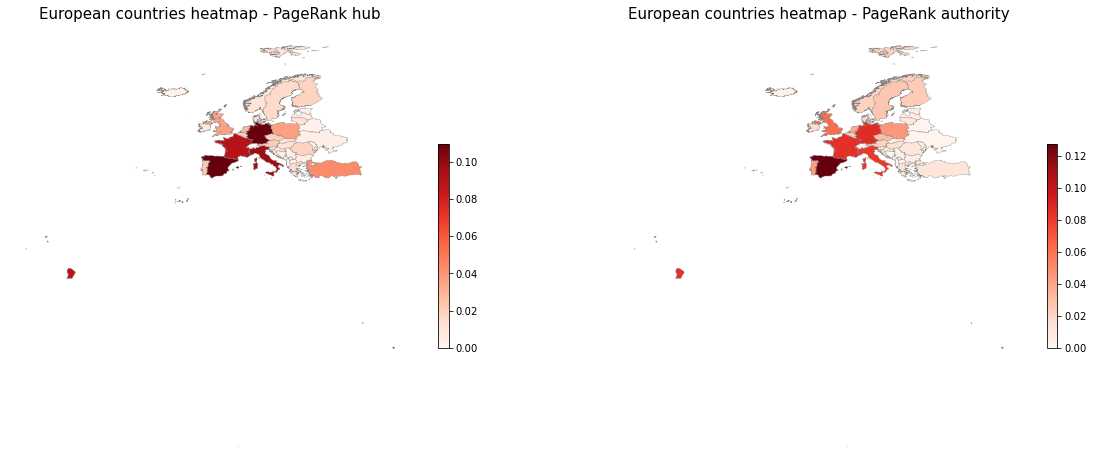

In [ ]:
# deg_list = ['in degree', 'out degree', 'PageRank hub', 'PageRank autority']
#fig4, ax4 = plt.subplots(1,4, figsize=(20,15))
plt_list = ['PageRank hub', 'PageRank authority']
fig4, ax4 = plt.subplots(1,2, figsize=(20,15))

for i in range(len(plt_list)):
    european_df.plot(column=plt_list[i], ax=ax4[i], edgecolor='0.5', linewidth=0.3, cmap='Reds')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df[plt_list[i]].min(), 
                                              vmax=european_df[plt_list[i]].max()), cmap='Reds')
    ax4[i].axis('off')
    fig4.colorbar(sm, ax=ax4[i], shrink=0.25)
    ax4[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)

# ax4 = np.reshape(ax4, (2,2))
# plt.savefig('eu_pagerank.png')

## Erasmus exchanges vs total students enrolled per country

In [ ]:
# dataset containing for each european university the students enrolled in ISCED 5-7 (tertiary education and master degree)
isced57_df = pd.read_csv("eter-export-2016_loc.csv", delimiter=';', on_bad_lines='skip')
isced57_df.dropna(inplace=True)
for index in range(len(isced57_df['Institution Name'])):
    if isced57_df.iat[index,0] != isced57_df.iat[index,0].upper():
        isced57_df.iat[index,0] = isced57_df.iat[index,0].upper()


        
# dropping all the values having too many numbers after comma
mask = isced57_df['Total students enrolled ISCED 5-7'].str.contains(',', na=False)
isced57_df = isced57_df[~mask]

# dropping rows with undefined values
isced57_df = isced57_df[~isced57_df['Total students enrolled ISCED 5-7'].isin(['m','a','c','xr','s'])]

# changing country codes accordingly to european_df ones
isced57_df['Country Code'][isced57_df['Country Code'] == 'GR'] = 'EL'

isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].astype(float)
isced57_df['Total students enrolled ISCED 5-7'] = isced57_df['Total students enrolled ISCED 5-7'].round()
# count total number of enrolled students for each country
isced57_df = isced57_df.groupby(['Country Code'])['Total students enrolled ISCED 5-7'].sum().reset_index()

european_df_w = pd.merge(left=isced57_df, right=european_df, how='right', left_on='Country Code', right_on='iso2_code')
european_df_w = gpd.GeoDataFrame(european_df_w, geometry = 'geometry')

print('Top 10 countries for students enrollment')
display(european_df_w[['country', 'Total students enrolled ISCED 5-7']].sort_values('Total students enrolled ISCED 5-7',
                                                                                    ascending=False).head(10))

Top 10 countries for students enrollment


country  Total students enrolled ISCED 5-7
31          Turkey                          7107650.0
24         Germany                          2625241.0
11  United Kingdom                          2263020.0
28           Italy                          1797986.0
9            Spain                          1491419.0
26          Poland                          1418588.0
12     Netherlands                           720583.0
25          Greece                           704969.0
20          Sweden                           438578.0
4         Portugal                           323467.0

In [ ]:
european_df_w['weight_pr_hub'] = european_df_w['PageRank hub']/european_df_w['Total students enrolled ISCED 5-7']
european_df_w['weight_pr_aut'] = european_df_w['PageRank authority']/european_df_w['Total students enrolled ISCED 5-7']

# threshold set because some countries had too big values wrt the average
european_df_w.loc[european_df_w['weight_pr_hub'] > 2*10**(-7), 'weight_pr_hub'] = 2*10**(-7)
european_df_w.loc[european_df_w['weight_pr_aut'] > 2*10**(-7), 'weight_pr_aut'] = 2*10**(-7)
# maybe set better this thresholds

eu_w_copy = european_df_w.copy()
eu_w_copy.dropna(inplace = True)
# Countries ordered by weighted PageRank hub score
eu_w_copy.sort_values('weight_pr_hub', ascending=False, inplace=True)
eu_w_copy.reset_index(drop=True, inplace=True)
display(eu_w_copy[['country', 'weight_pr_hub']])
# Countries ordered by weighted PageRank authority score
eu_w_copy.sort_values('weight_pr_aut', ascending=False, inplace=True)
eu_w_copy.reset_index(drop=True, inplace=True)
display(eu_w_copy[['country', 'weight_pr_aut']])


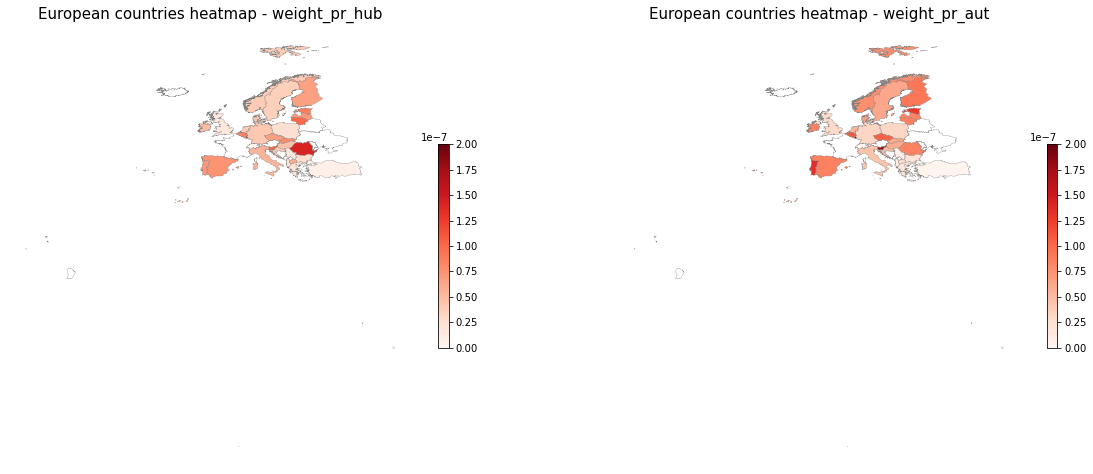

In [ ]:
fig7, ax7 = plt.subplots(1,2, figsize=(20,15))
plt_list = ['weight_pr_hub', 'weight_pr_aut']
for i in range(len(plt_list)):
    # european_df_w.drop(european_df_w[plt_list[i]].idxmax(), inplace=True)
    european_df_w.plot(column=plt_list[i], ax=ax7[i], edgecolor='0.5', linewidth=0.3, cmap='Reds')
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=european_df_w[plt_list[i]].min(), 
                                              vmax=european_df_w[plt_list[i]].max()), cmap='Reds')
    ax7[i].axis('off')
    fig7.colorbar(sm, ax=ax7[i], shrink=0.25)
    ax7[i].set_title('European countries heatmap - ' + plt_list[i], fontsize=15)
    
# plt.savefig('eu_pagerank_weight.png')

## GeoPlot for Communities

Text(0.5, 1.0, 'European countries - Commmunity')

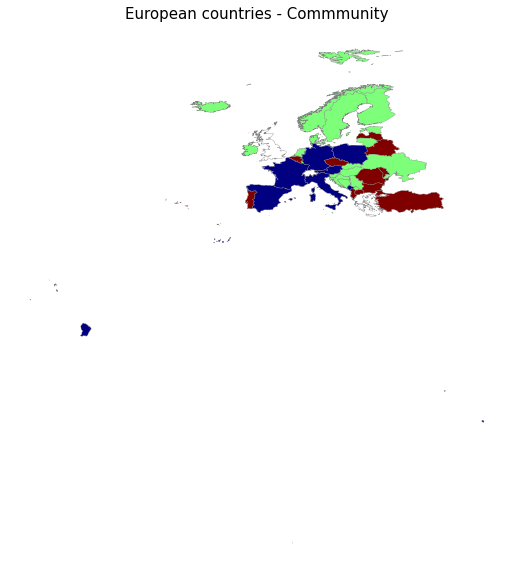

In [ ]:
node_comm.loc[node_comm['Nodes'] == 'Moldova, Republic of', 'Nodes'] = 'Moldova'
node_comm.loc[node_comm['Nodes'] == 'North Macedonia', 'Nodes'] = 'Macedonia'
node_comm.loc[node_comm['Nodes'] == 'XK', 'Nodes'] = 'Kosovo'

eu_communities = european_df.copy()
eu_communities['Community'] = node_comm[node_comm['Nodes'].isin(european_countries)]['Community']

fig5, ax5 = plt.subplots(figsize=(10,10))
eu_communities.plot(column='Community', ax=ax5, edgecolor='0.5', linewidth=0.3, cmap='jet')
ax5.axis('off')
ax5.set_title('European countries - Commmunity', fontsize=15)

# plt.savefig('eu_community.png')